# Notes/Questions to discuss:
1.	I removed 59 SPI companies without Total ESG Score, 1 duplicate company (Schindler, see 1.4), and 4 S&P 500 companies without Total ESG Score **(see section 1.3.1)**.</br>
    *Remark Marisa: Makes sense*
2.	After removing non-Swiss SPI companies and non-US S&P companies, we have 134 Swiss companies in the SPI group and 280 US companies in the S&P 500 group (also in the final dataset for analysis).
    *Remark Marisa: I would remove non swiss companies from SPI. Also only take US companies from S&P 500 because 96% are from the US. I added code to show this so we can argue properly*
3.	I removed financial indicators due to a large amount of missing data: PE_Ratio, EBITDA_Margin_%, Debt_to_Equity, Current_Ratio, and Operating_Cash_Flow **(see 1.3.5)**.</br>
    *Remark Marisa: Makes sense to me.*
4.	Depending on the metrics and industries chosen for further analysis, we may need to remove additional S&P 500 data due to the unbalanced size of the two datasets and missing values. However, the S&P 500 dataset is mainly used for support and comparison, so we do not perform a deep analysis on it and adjust it according to the SPI dataset **(see 1.3.5)**. </br>
    *Remark Marisa: Fine for me for now. But I will keep it in mind for further analysis*
5.	Outliers should be addressed (keep or remove) during the analysis and comparison of specific metrics based on their observed distributions **(see 4.3)**. </br>
    *Remark Marisa: Same as above. I would keep these for now and think about removing them when we analyse them for our research questions.*
6.	The merged and cleaned dataset is saved as `cleaned_combined_data.csv` in the Data folder. Additional columns have been added:
    - Company_Type to identify SPI vs S&P 500 companies
    - ESG Risk Classification according to the ESG Risk Ratings Methodology **(see 5.2)**

# 1. Introduction

ESG performance has become an important factor in corporate strategy and financial markets. Meta-analyses show that a majority of studies find a positive relationship between ESG scores. However, there is also a non-negligible share of research reports that report neutral or even negative effects. (Friede et al., 2015; Whelan et al., 2021) Our project focuses on Swiss companies to examine whether ESG scores are positively linked to financial performance.

To address these mixed findings, we formulated the following research questions:

## Research Questions

1. What is the relationship between ESG scores and financial performance for Swiss listed companies?
2. What is the effect of the industry type on this relationship, focusing on the top 5 industries in Switzerland.
3. If there is a clear dependency of ESG on financial performance, how do the individual effects of Environmental (E), Social (S), and Governance (G) factors compare in explaining this relationship?
4. How does the relationship between financial performance and ESG scores behave of Swiss companies compared to peers worldwide?

# 2. Data Acquisition

## 2.1 Data Source

We collect data from two main company groups:
- The first consists of all Swiss listed firms included in the Swiss Performance Index (SPI) — approximately 230 companies across various sectors. 
- The second serves as a global benchmark, represented by the S&P 500 Index, which includes 500 leading U.S.-listed companies.

For both datasets, financial and ESG data were retrieved via the Yahoo Finance API by company ticker. 

Yahoo Finance does not provide official API documentation, we found two reliable public technical references ([Ranaroussi’s yfinance Documentation](https://ranaroussi.github.io/yfinance/reference/index.html) and the [AlgoTrading101 API Guide](https://algotrading101.com/learn/yahoo-finance-api-guide/) that we can consult to ensure data accuracy and consistency.

### 2.1.1 Company List Compilation

We first collected the company tickers from publicly available Wikipedia pages: [Swiss Performance Index (SPI)](https://en.wikipedia.org/wiki/Swiss_Performance_Index) and [S&P 500 Index](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). These sources provide an accessible and structured overview of companies and their corresponding tickers.

However, both indices are dynamic — the composition of listed companies changes over time due to mergers, delistings, and index rebalancing. The SPI table on Wikipedia references data as of September 18, 2020 and is therefore not up to date. To ensure that our analysis reflects the most recent constituents, we cross-checked the Wikipedia lists against a real-time source from [Investing.com](https://www.investing.com/indices/swiss-performance-components) on the day of data acquisition (October 17, 2025), which provides the current SPI components but without ticker symbols.

Then, we used Excel’s VLOOKUP function to systematically identify and resolve mismatches between the Wikipedia and real-time lists. Missing or renamed tickers were manually verified and corrected. The resulting files contain finalized company tickers for both the SPI and S&P 500 datasets, which were then used for data extraction via the Yahoo Finance API.

The final lists of both company groups and the detailed cross-checking process are documented in the Excel file “company list.xlsx”, located in the folder “Company List”.

### 2.1.2 Variables Collected

We compile variables across several dimensions, summarized below:
1. Company Information:
Company name, ticker, currency, industry, sector, and country.

2. Financial and Market Data:
To capture firm performance from multiple perspectives, we categorize financial variables as follows:
- Stock Price: 
Collected for two reference dates: 2024-12-31 (to align with the fiscal-year-end snapshot) and 2025-10-17 (the date of data acquisition).
- Profitability Metrics:
Revenue, Net Income, Operating Margin, Gross Margin, ROE, ROA, Profit Margin, EBITDA Margin, and EPS. These variables reflect operational efficiency and profitability and allow testing whether ESG leaders exhibit superior or more stable performance.
- Valuation Metrics:
Market Capitalization, P/E Ratio, P/B Ratio, and Annual Return — used to assess whether the market values ESG leaders at a premium and whether they show lower risk.
- Risk and Stability Metrics:
Beta, Debt-to-Equity Ratio, Current Ratio, and (Operating / Free) Cash Flow. These indicators provide insight into a firm’s leverage, liquidity, and resilience.
- Growth Metrics:
Revenue Growth and other expansion indicators, used to test whether ESG-oriented firms achieve higher or more sustainable growth.

All financial data correspond to a **2024-12-31** snapshot, ensuring alignment with the same reporting period as the ESG scores.

3. ESG Scores:
The ESG dataset includes both aggregate and dimension-level measures:
- Total ESG Risk Score, Environmental Risk Score, Social Risk Score, and Governance Risk Score.
- Highest Controversy Level (0–5 scale), capturing the severity of historical ESG-related incidents.
- ESG Performance Category — including UNDER_PERF, AVG_PERF, and OUT_PERF — indicating whether the company underperforms, performs similarly to, or outperforms peers in ESG practices.

## 2.2 Data Extraction via API

We developed the following Python script to extract data via the Yahoo Finance API. By modifying the input parameter (`swiss_companies.txt` and `S&P_companies.txt`), we generated separate datasets for Swiss and S&P companies.

```python
import yfinance as yf
import pandas as pd
import time
from datetime import datetime
import numpy as np

def get_revenue_growth(ticker_obj):
    """Revenue Growth"""
    try:
        financials = ticker_obj.financials
        if financials is not None and not financials.empty and 'Total Revenue' in financials.index:
            revenues = financials.loc['Total Revenue'].sort_index()
            if len(revenues) >= 2:
                latest = revenues.iloc[-1]
                previous = revenues.iloc[-2]
                if previous != 0 and not pd.isna(previous) and not pd.isna(latest):
                    growth = ((latest - previous) / abs(previous)) * 100
                    return round(growth, 2)
        return None
    except:
        return None

def get_ebitda_margin(ticker_obj):
    """EBITDA Margin"""
    try:
        info = ticker_obj.info
        ebitda = info.get('ebitda', None)
        revenue = info.get('totalRevenue', None)
        if ebitda and revenue and revenue != 0:
            margin = (ebitda / revenue) * 100
            return round(margin, 2)
        return None
    except:
        return None

def get_stock_price_at_date(ticker_obj, target_date='2024-12-31'):
    """Stock Price around end of 2024"""
    try:
        hist = ticker_obj.history(start='2024-12-20', end='2025-01-10')
        
        if not hist.empty:
            return round(hist['Close'].iloc[-1], 2)
        return None
    except:
        return None

def get_beta(ticker_obj):
    """Beta value"""
    try:
        info = ticker_obj.info
        beta = info.get('beta', None)
        if beta:
            return round(beta, 3)
        return None
    except:
        return None
    
def volatility(ticker_obj):
    """Annualized Volatility based on daily returns"""
    try:
        hist = ticker.history(start="2024-01-01", end="2024-12-31")['Close']
        if not hist.empty:
            daily_returns = hist.pct_change().dropna()
            volatility = daily_returns.std() * np.sqrt(252)  # Assuming 252 trading days
            return round(volatility, 2)
        return None
    except:
        return None

def get_comprehensive_data(ticker_symbol, target_date='2024-12-31'):
    """
    get ESG scores and key financial metrics for a given ticker.
    target_date: '2024-12-31'
    """
    try:
        ticker = yf.Ticker(ticker_symbol)
        info = ticker.info
        
        # === 1. company info ===
        company_name = info.get('longName', 'N/A')
        currency = info.get('currency', 'N/A')
        industry = info.get('industry', 'N/A')
        sector = info.get('sector', 'N/A')
        country = info.get('country', 'N/A')
        
        # === 2. ESG ===
        esg_scores = ticker.sustainability
        if esg_scores is not None and not esg_scores.empty:
            total_esg = esg_scores.loc['totalEsg'].values[0] if 'totalEsg' in esg_scores.index else None
            env_score = esg_scores.loc['environmentScore'].values[0] if 'environmentScore' in esg_scores.index else None
            social_score = esg_scores.loc['socialScore'].values[0] if 'socialScore' in esg_scores.index else None
            gov_score = esg_scores.loc['governanceScore'].values[0] if 'governanceScore' in esg_scores.index else None
            esg_performance = esg_scores.loc['esgPerformance'].values[0] if 'esgPerformance' in esg_scores.index else None
            highest_controversy = esg_scores.loc['highestControversy'].values[0] if 'highestControversy' in esg_scores.index else None
        else:
            total_esg = env_score = social_score = gov_score = esg_performance = highest_controversy = None
        
        # === 3. stock price ===
        stock_price = get_stock_price_at_date(ticker, target_date)
        current_price = info.get('currentPrice', None) or info.get('regularMarketPrice', None)
        
        # === 4. key financial indicators ===
        
        # valuation & size
        market_cap = info.get('marketCap', None)
        pe_ratio = info.get('trailingPE', None)
        pb_ratio = info.get('priceToBook', None)
        annual_return = info.get('52WeekChange', None)
        
        # profitibility
        revenue = info.get('totalRevenue', None)
        net_income = info.get('netIncomeToCommon', None)
        operating_margin = info.get('operatingMargins', None)
        gross_margin = info.get('grossMargins', None)
        roe = info.get('returnOnEquity', None)
        roa = info.get('returnOnAssets', None)
        profit_margin = info.get('profitMargins', None)
        ebitda_margin = get_ebitda_margin(ticker)
        eps = info.get('trailingEps', None)
        
        # risk/stability
        beta = get_beta(ticker)
        debt_to_equity = info.get('debtToEquity', None)
        current_ratio = info.get('currentRatio', None)
        cash_flow = info.get('operatingCashflow', None)
        
        # growth
        revenue_growth = get_revenue_growth(ticker)
        
        # convert ratios to percentages where applicable
        if operating_margin: operating_margin = round(operating_margin * 100, 2)
        if gross_margin: gross_margin = round(gross_margin * 100, 2)
        if roe: roe = round(roe * 100, 2)
        if roa: roa = round(roa * 100, 2)
        if profit_margin: profit_margin = round(profit_margin * 100, 2)
        if pe_ratio: pe_ratio = round(pe_ratio, 2)
        if pb_ratio: pb_ratio = round(pb_ratio, 2)
        if eps: eps = round(eps, 2)
        if current_ratio: current_ratio = round(current_ratio, 2)
        if debt_to_equity: debt_to_equity = round(debt_to_equity, 2)
        if annual_return: annual_return = round(annual_return * 100, 2)
        
        # build result dict
        result = {
            # basic info
            'Ticker': ticker_symbol,
            'Company_Name': company_name,
            'Currency': currency,
            'Data_Date': target_date,
            'Industry': industry,
            'Sector': sector,
            'Country': country,
            
            # ESG
            'Total_ESG_Score': total_esg,
            'Environmental_Score': env_score,
            'Social_Score': social_score,
            'Governance_Score': gov_score,
            'ESG_Performance': esg_performance,
            'Highest_Controversy': highest_controversy,
            
            # Stock Price
            'Stock_Price': stock_price,
            'Current_Price': current_price,
            
            # valuation & size
            'Market_Cap': market_cap,
            'PE_Ratio': pe_ratio,
            'PB_Ratio': pb_ratio,
            'Annual_Return_Pct': annual_return,
            
            # profitibility (%)
            'Revenue': revenue,
            'Net_Income': net_income,
            'Operating_Margin_Pct': operating_margin,
            'Gross_Margin_Pct': gross_margin,
            'ROE_Pct': roe,
            'ROA_Pct': roa,
            'Profit_Margin_Pct': profit_margin,
            'EBITDA_Margin_Pct': ebitda_margin,
            'EPS': eps,
            
            # risk/stability
            'Beta': beta,
            'Debt_to_Equity': debt_to_equity,
            'Current_Ratio': current_ratio,
            'Operating_Cash_Flow': cash_flow,
            
            # Growth (%)
            'Revenue_Growth_Pct': revenue_growth,
            
            # Status
            'Status': 'Success'
        }
        
        return result
        
    except Exception as e:
        return {
            'Ticker': ticker_symbol,
            'Company_Name': 'Error',
            'Currency': None,
            'Data_Date': target_date,
            'Industry': None,
            'Sector': None,
            'Country': None,
            'Total_ESG_Score': None,
            'Environmental_Score': None,
            'Social_Score': None,
            'Governance_Score': None,
            'ESG_Performance': None,
            'Highest_Controversy': None,
            'Stock_Price': None,
            'Current_Price': None,
            'Revenue': None,
            'Net_Income': None,
            'Operating_Margin_Pct': None,
            'Gross_Margin_Pct': None,
            'ROE_Pct': None,
            'ROA_Pct': None,
            'Profit_Margin_Pct': None,
            'EBITDA_Margin_Pct': None,
            'EPS': None,
            'Market_Cap': None,
            'PE_Ratio': None,
            'PB_Ratio': None,
            'Annual_Return_Pct': None,
            'Beta': None,
            'Debt_to_Equity': None,
            'Current_Ratio': None,
            'Operating_Cash_Flow': None,
            'Revenue_Growth_Pct': None,
            'Status': f'Error: {str(e)}'
        }

def read_tickers_from_file(filename):
    """read ticker symbols from a text file, ignoring comments and empty lines"""
    tickers = []
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):
                    tickers.append(line)
        return tickers
    except FileNotFoundError:
        print(f"Error: File not found '{filename}'")
        return []
    except Exception as e:
        print(f"Error when reading the file: {e}")
        return []

def main():
    # === parameters ===
    input_file = 'Company List/swiss_companies.txt'
    target_date = '2024-12-31'
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f'esg_financial_analysis_{target_date.replace("-", "")}_{timestamp}.csv'
    
    # reading tickers
    print(f"\nReading input file: {input_file}")
    tickers = read_tickers_from_file(input_file)
    
    if not tickers:
        print("No valid ticker symbols found. Please check the input file.")
        return
    
    print(f"Successfully read {len(tickers)} tickers.")
    print("-" * 90)
    
    # store all results
    all_data = []
    
    # iterate through each ticker
    for i, ticker in enumerate(tickers, 1):
        print(f"\n[{i}/{len(tickers)}] Processing {ticker}...")
        
        # get comprehensive data
        result = get_comprehensive_data(ticker, target_date)
        all_data.append(result)
        
        # show brief result
        if result['Status'] == 'Success':
            print(f"  ✓ {result['Company_Name']}")
            print(f"    Total ESG Score: {result['Total_ESG_Score']} (E:{result['Environmental_Score']}, S:{result['Social_Score']}, G:{result['Governance_Score']})")
            print(f"    Stock Price: {result['Stock_Price']} {result['Currency']}")
            print(f"    Market Cap: {result['Market_Cap']:,.0f}" if result['Market_Cap'] else "    Market Cap: N/A")
            print(f"    ROE: {result['ROE_Pct']}% | Beta: {result['Beta']}")
        else:
            print(f"  ✗ {result['Status']}")
        
        # delay to avoid too many requests at once
        if i < len(tickers):
            time.sleep(1.5)
    
    # convert into DataFrame
    df = pd.DataFrame(all_data)
    
    # save as CSV
    print("\n" + "=" * 90)
    print(f"Saving data to: {output_file}")
    df.to_csv(output_file, index=False, encoding='utf-8-sig')
    
    # statistics
    print("-" * 90)
    print("Data collection completed!")
    print(f"Total companies: {len(tickers)}")
    print(f"Successful: {len(df[df['Status'] == 'Success'])}")
    print(f"Failed: {len(df[df['Status'] != 'Success'])}")
    
    # data quality checks
    print("\nData completeness check:")
    esg_complete = len(df[df['Total_ESG_Score'].notna()])
    price_complete = len(df[df['Stock_Price'].notna()])
    roe_complete = len(df[df['ROE_Pct'].notna()])
    beta_complete = len(df[df['Beta'].notna()])
    
    print(f"  ESG data complete: {esg_complete}/{len(df)} ({esg_complete/len(df)*100:.1f}%)")
    print(f"  Stock price data complete: {price_complete}/{len(df)} ({price_complete/len(df)*100:.1f}%)")
    print(f"  ROE data complete: {roe_complete}/{len(df)} ({roe_complete/len(df)*100:.1f}%)")
    print(f"  Beta data complete: {beta_complete}/{len(df)} ({beta_complete/len(df)*100:.1f}%)")
    
    print(f"\n✓ Data saved to: {output_file}")
    print("=" * 90)
    
    # preview data
    print("\nData preview (first 5 rows):")
    preview_cols = ['Ticker', 'Company_Name', 'Total_ESG_Score', 'Stock_Price', 
                    'Market_Cap', 'ROE_Pct', 'Beta', 'Status']
    print(df[preview_cols].head().to_string(index=False))

if __name__ == "__main__":
    main()
```

The complete implementation can be found in the Data folder as data_acquisition.py, and the downloaded datasets are stored in the Data folder as esg_financial_analysis_spi.csv and esg_financial_analysis_sp500.csv.

# 3. Data Cleansing

Following the data acquisition process, the raw datasets were imported for cleansing and preprocessing. This step involved loading the data and necessary packages, checking for missing or inconsistent values, identifying outliers, and ensuring all financial metrics and ESG scores were correctly formatted for further analysis.

## 3.1  Import packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pathlib import Path
from sklearn.preprocessing import StandardScaler

## 3.2  Load Data

Firstly, we load the two datasets to begin the data cleansing process. 

In [5]:
spi = pd.read_csv(Path("Data/esg_financial_analysis_spi.csv"))
sp500 = pd.read_csv(Path("Data/esg_financial_analysis_sp500.csv"))

Then we check the structure of the SPI dataset. It contains 201 observations with 34 variables.
On the first glance, we see that we don't have all variables of all observations. We therefore need to look into that closer.
(i.e. 142 Total ESG Scores out of 201 observations)

In [6]:
# SPI dataset overview
print(spi.shape)
spi.describe()

(201, 34)


,Total_ESG_Score,Environmental_Score,Social_Score,Governance_Score,Highest_Controversy,Stock_Price,Current_Price,Market_Cap,PE_Ratio,PB_Ratio,...,ROE_Pct,ROA_Pct,Profit_Margin_Pct,EBITDA_Margin_Pct,EPS,Beta,Debt_to_Equity,Current_Ratio,Operating_Cash_Flow,Revenue_Growth_Pct
count,142.000000,71.000000,71.000000,71.000000,141.000000,196.000000,199.000000,1.990000e+02,150.000000,198.000000,...,186.000000,190.000000,194.000000,162.000000,194.000000,189.000000,158.000000,170.000000,1.770000e+02,196.000000
mean,22.166127,5.776479,8.240423,5.491690,0.574468,834.992959,1017.642378,9.678245e+09,29.586800,3.581717,...,4.347473,2.742158,41.736392,-56.286296,475.215722,0.664238,114.213291,7.071059,8.240547e+08,19.177653
std,7.795570,4.963638,3.330291,2.194745,0.880211,6992.709729,9313.699001,2.940864e+10,40.782032,13.400904,...,44.542110,7.851904,290.066171,696.720688,6191.892435,0.469562,301.059794,58.167139,2.949556e+09,220.548477
min,8.560000,0.000000,0.640000,1.070000,0.000000,0.050000,0.021000,1.046500e+05,0.040000,-51.520000,...,-288.140000,-27.200000,-133.720000,-8713.510000,-28.810000,-0.464000,0.280000,0.020000,-4.749700e+09,-100.000000
25%,15.647500,1.735000,5.755000,4.235000,0.000000,25.152500,23.275000,3.087133e+08,13.937500,0.865000,...,2.012500,0.632500,1.062500,5.557500,0.257500,0.299000,21.365000,1.022500,1.764100e+07,-4.537500
50%,22.320000,3.920000,8.790000,5.010000,0.000000,77.185000,80.200000,1.277350e+09,19.425000,1.675000,...,8.285000,2.225000,8.055000,12.760000,4.020000,0.664000,56.305000,1.505000,8.063400e+07,1.180000
75%,27.620000,9.985000,10.495000,6.795000,1.000000,220.257500,223.500000,4.349876e+09,30.932500,3.747500,...,15.940000,6.605000,21.027500,23.687500,9.702500,0.964000,109.325000,2.387500,4.170490e+08,7.077500
max,49.050000,17.020000,16.750000,10.960000,4.000000,97134.130000,130600.000000,2.250000e+11,443.330000,172.410000,...,163.700000,50.970000,3663.790000,116.370000,86227.180000,2.164000,3322.760000,758.290000,2.078800e+10,3028.010000


We do the same for the S&P 500 dataset. It contains 503 observations with 34 variables.
Here we see as well that we have some NAs for certain variables.

In [7]:
# S&P 500 dataset overview
print(sp500.shape)
sp500.describe()

(503, 34)


,Total_ESG_Score,Environmental_Score,Social_Score,Governance_Score,Highest_Controversy,Stock_Price,Current_Price,Market_Cap,PE_Ratio,PB_Ratio,...,ROE_Pct,ROA_Pct,Profit_Margin_Pct,EBITDA_Margin_Pct,EPS,Beta,Debt_to_Equity,Current_Ratio,Operating_Cash_Flow,Revenue_Growth_Pct
count,300.000000,299.000000,299.000000,299.000000,300.000000,303.000000,303.000000,3.030000e+02,288.000000,303.000000,...,283.000000,299.000000,303.000000,282.000000,303.000000,300.000000,264.000000,283.000000,2.890000e+02,302.000000
mean,20.164533,6.871003,8.532174,4.794582,1.930000,189.875446,202.044719,1.521832e+11,38.558889,-3.138020,...,27.100919,6.966120,14.526073,28.319433,7.003432,0.981867,137.596364,1.751272,6.891888e+09,5.838278
std,6.717920,5.474978,3.392135,2.299318,0.752987,339.840025,343.964816,4.808831e+11,74.027724,127.439643,...,51.741107,5.957017,13.684727,16.779211,10.369405,0.428993,202.053465,3.759739,1.667697e+10,14.167928
min,7.120000,0.040000,0.890000,1.430000,0.000000,9.170000,8.140000,6.908318e+09,4.850000,-2181.440000,...,-183.280000,-3.730000,-71.710000,-9.300000,-16.550000,0.023000,0.050000,0.040000,-1.076700e+10,-45.710000
25%,15.102500,2.255000,6.225000,3.380000,2.000000,57.130000,62.100000,2.035670e+10,17.295000,1.600000,...,9.105000,3.205000,7.495000,16.960000,2.245000,0.669500,46.792500,0.875000,1.256918e+09,-0.155000
50%,19.630000,5.690000,8.610000,4.360000,2.000000,109.290000,122.870000,3.940400e+10,24.215000,3.060000,...,15.200000,5.400000,13.630000,24.995000,4.860000,0.998500,74.615000,1.220000,2.617000e+09,4.255000
75%,23.932500,10.775000,10.625000,5.490000,2.000000,224.685000,238.605000,1.075000e+11,34.490000,6.865000,...,29.045000,8.660000,20.550000,37.205000,9.270000,1.230250,155.700000,1.775000,5.611000e+09,9.955000
max,41.260000,24.790000,17.760000,20.210000,5.000000,4845.740000,4952.310000,4.430000e+12,755.640000,175.810000,...,514.460000,53.090000,72.960000,92.610000,143.620000,2.686000,2149.330000,60.310000,1.360000e+11,114.200000


## 3.3 Check Missing Data

*Remark MT: cant we remove this first step because we handle it in more detail later?* </br>
We now look into more detail of missing data: We look at the count and the percentage of the amount of data missing. </br>
Especially for the ESG, we see some missing data which we need to look into closer.

In [8]:
def missing_summary(df, name):
    missing_count = df.isnull().sum()
    missing_pct = (missing_count / len(df) * 100).round(2)
    return pd.DataFrame({
        "Dataset": name,
        "Missing Count": missing_count,
        "Missing %": missing_pct
    })

In [9]:
missing_summary(spi, "SPI")

,Dataset,Missing Count,Missing %
Ticker,SPI,0,0.00
Company_Name,SPI,3,1.49
Currency,SPI,2,1.00
Data_Date,SPI,1,0.50
Industry,SPI,7,3.48
Sector,SPI,7,3.48
Country,SPI,7,3.48
Total_ESG_Score,SPI,59,29.35
Environmental_Score,SPI,130,64.68
Social_Score,SPI,130,64.68


In [10]:
missing_summary(sp500, "SP500")

,Dataset,Missing Count,Missing %
Ticker,SP500,0,0.00
Company_Name,SP500,200,39.76
Currency,SP500,200,39.76
Data_Date,SP500,200,39.76
Industry,SP500,200,39.76
Sector,SP500,200,39.76
Country,SP500,200,39.76
Total_ESG_Score,SP500,203,40.36
Environmental_Score,SP500,204,40.56
Social_Score,SP500,204,40.56


### 3.3.1 Missing ESG data

In [11]:
def check_esg_missing(df, name):
    """Check proportion of missing ESG scores"""
    esg_columns = ['Total_ESG_Score', 'Environmental_Score', 'Social_Score', 'Governance_Score', 'ESG_Performance', 'Highest_Controversy']
    esg_scores_columns = ['Total_ESG_Score', 'Environmental_Score', 'Social_Score', 'Governance_Score']
    
    print(f"\n{name} - ESG Data Availability:")
    for col in esg_columns:
        if col in df.columns:
            missing_count = df[col].isnull().sum()
            missing_pct = (missing_count / len(df) * 100)
            print(f"  {col}: {missing_count}/{len(df)} missing ({missing_pct:.2f}%)")
    
    # Overall ESG availability
    has_total_esg = df[['Total_ESG_Score']].notnull().all(axis=1)
    has_all_esg_scores = df[esg_scores_columns].notnull().all(axis=1)
    has_all_esg_data = df[esg_columns].notnull().all(axis=1)
    companies_with_total_esg = has_total_esg.sum()
    companies_without_total_esg = len(df) - companies_with_total_esg
    companies_with_all_esg_scores = has_all_esg_scores.sum()
    companies_with_all_esg_data = has_all_esg_data.sum()
    
    print(f"\n  Companies WITHOUT Total ESG scores: {companies_without_total_esg} ({companies_without_total_esg/len(df)*100:.2f}%)")
    print(f"  Companies WITH Total ESG score: {companies_with_total_esg} ({companies_with_total_esg/len(df)*100:.2f}%)")
    print(f"  Companies WITH all ESG scores: {companies_with_all_esg_scores} ({companies_with_all_esg_scores/len(df)*100:.2f}%)")
    print(f"  Companies WITH all ESG data: {companies_with_all_esg_data} ({companies_with_all_esg_data/len(df)*100:.2f}%)")

spi_no_esg = check_esg_missing(spi, "SPI")
sp500_no_esg = check_esg_missing(sp500, "S&P 500")


SPI - ESG Data Availability:
  Total_ESG_Score: 59/201 missing (29.35%)
  Environmental_Score: 130/201 missing (64.68%)
  Social_Score: 130/201 missing (64.68%)
  Governance_Score: 130/201 missing (64.68%)
  ESG_Performance: 59/201 missing (29.35%)
  Highest_Controversy: 60/201 missing (29.85%)

  Companies WITHOUT Total ESG scores: 59 (29.35%)
  Companies WITH Total ESG score: 142 (70.65%)
  Companies WITH all ESG scores: 71 (35.32%)
  Companies WITH all ESG data: 71 (35.32%)

S&P 500 - ESG Data Availability:
  Total_ESG_Score: 203/503 missing (40.36%)
  Environmental_Score: 204/503 missing (40.56%)
  Social_Score: 204/503 missing (40.56%)
  Governance_Score: 204/503 missing (40.56%)
  ESG_Performance: 203/503 missing (40.36%)
  Highest_Controversy: 203/503 missing (40.36%)

  Companies WITHOUT Total ESG scores: 203 (40.36%)
  Companies WITH Total ESG score: 300 (59.64%)
  Companies WITH all ESG scores: 299 (59.44%)
  Companies WITH all ESG data: 299 (59.44%)


Summary: 

Missing ESG data in the S&P 500 dataset is negligible, but in SPI dataset, only 71/201 companies have full ESG data, and 142 have Total ESG Score as well as ESG_Performance indicator. Removing the 130 companies without detailed scores would be too much, instead, we could remove 59/201 SPI companies without the Total ESG Score, and consider dividing the remaining companies into two subgroups for further analysis: 
- 142 companies with Total ESG Score 
- and 71 with full ESG data

In [12]:
spi_esg = spi.dropna(subset=['Total_ESG_Score'])
print(spi_esg.shape)
print(spi_esg['Total_ESG_Score'].isnull().sum())

(142, 34)
0


In [13]:
sp500_esg = sp500.dropna(subset=['Total_ESG_Score'])
print(sp500_esg.shape)
print(sp500_esg['Total_ESG_Score'].isnull().sum())

(300, 34)
0


### 3.3.2 Country Issues

Next, we look at the countries of the companies to identify whether some firms listed in the SPI dataset are actually non-Swiss and to understand the distribution, in order to decide whether to exclude them.

In [14]:
non_swiss = spi_esg[spi_esg["Country"] != "Switzerland"]
print(non_swiss[['Ticker', 'Company_Name', 'Country', 'Total_ESG_Score']].to_string())

      Ticker                                      Company_Name        Country  Total_ESG_Score
21    AMS.SW                                      ams-OSRAM AG        Austria            17.61
44   COPN.SW                        Cosmo Pharmaceuticals N.V.        Ireland            29.37
124  LLBN.SW  Liechtensteinische Landesbank Aktiengesellschaft  Liechtenstein            28.14
156  VPBN.SW                                        VP Bank AG  Liechtenstein            28.06
170  PKTM.SW                                PIERER Mobility AG        Austria             8.88


Considering that 5 out of 201 companies in the SPI dataset are non-Swiss, we decided to remove these non-Swiss firms to ensure better consistency and comparability in our analysis.

In [15]:
spi_esg = spi_esg[spi_esg["Country"] == "Switzerland"]

Next, we check if companies in the SPI are also in the S&P 500, as a few multinational corporations might appear in both the SPI and S&P 500 datasets.

In [16]:
sp500_swiss = sp500_esg[sp500_esg["Country"] == "Switzerland"]
print(sp500_swiss[['Ticker', 'Company_Name', 'Country', 'Total_ESG_Score']].to_string())

    Ticker   Company_Name      Country  Total_ESG_Score
23    AMCR      Amcor plc  Switzerland            14.31
41    APTV      Aptiv PLC  Switzerland            12.89
101     CB  Chubb Limited  Switzerland            20.12
206   GRMN    Garmin Ltd.  Switzerland            21.23


In [17]:
check_duplicates = sp500_esg['Company_Name'].tolist()
matching_spi = spi_esg[spi_esg['Company_Name'].isin(check_duplicates)]

print(matching_spi[['Ticker', 'Company_Name', 'Country', 'Total_ESG_Score']].to_string())

Empty DataFrame
Columns: [Ticker, Company_Name, Country, Total_ESG_Score]
Index: []


So: No overlapping companies

We want to see the distribution of countries in the S&P dataset. Because approx 96% of the companies are based in the US, we decide to focus on Swiss vs. US companies.

In [18]:
country_counts = sp500_esg['Country'].value_counts(dropna=False)
country_pct = (country_counts / len(sp500_esg) * 100).round(2)

country_summary = pd.DataFrame({
    'Count': country_counts,
    'Percentage (%)': country_pct
})

print("S&P 500 — Country distribution:")
display(country_summary)

S&P 500 — Country distribution:


,Count,Percentage (%)
Country,,
United States,280,93.33
Ireland,9,3.00
Switzerland,4,1.33
United Kingdom,3,1.00
Bermuda,1,0.33
Canada,1,0.33
Netherlands,1,0.33
Singapore,1,0.33


In [19]:
sp500_nonUS = sp500_esg[sp500_esg["Country"] != "United States"]
print(sp500_nonUS[['Ticker', 'Company_Name', 'Country', 'Total_ESG_Score']].to_string())

    Ticker                                 Company_Name         Country  Total_ESG_Score
4      ACN                                Accenture plc         Ireland            12.88
16    ALLE                                 Allegion plc         Ireland            20.10
23    AMCR                                    Amcor plc     Switzerland            14.31
35     AON                                      Aon plc         Ireland            13.64
41    APTV                                    Aptiv PLC     Switzerland            12.89
42    ACGL                      Arch Capital Group Ltd.         Bermuda            18.36
101     CB                                Chubb Limited     Switzerland            20.12
160    ETN                        Eaton Corporation plc         Ireland            19.80
206   GRMN                                  Garmin Ltd.     Switzerland            21.23
266    JCI           Johnson Controls International plc         Ireland            14.97
289    LIN           

Again, we remove those non-US companies.

In [20]:
sp500_esg = sp500_esg[sp500_esg["Country"] == "United States"]

### 3.3.3 Fix Company Name

In [21]:
spi_esg[spi_esg["Company_Name"].isna()]

,Ticker,Company_Name,Currency,Data_Date,Industry,Sector,Country,Total_ESG_Score,Environmental_Score,Social_Score,...,ROA_Pct,Profit_Margin_Pct,EBITDA_Margin_Pct,EPS,Beta,Debt_to_Equity,Current_Ratio,Operating_Cash_Flow,Revenue_Growth_Pct,Status
197,GALD.SW,NaN,CHF,12/31/24,Drug Manufacturers - Specialty & Generic,Healthcare,Switzerland,19.8,3.84,11.03,...,3.65,8.06,20.98,1.28,NaN,36.84,1.09,951000000.0,7.85,Success


In [22]:
spi_esg['Company_Name'].fillna("Galderma", inplace=True)
spi_esg[spi_esg["Company_Name"].isna()]

/var/folders/hz/1v624m_x7tb_4prfm9vkrrjw0000gn/T/ipykernel_14027/2277365914.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spi_esg['Company_Name'].fillna("Galderma", inplace=True)


,Ticker,Company_Name,Currency,Data_Date,Industry,Sector,Country,Total_ESG_Score,Environmental_Score,Social_Score,...,ROA_Pct,Profit_Margin_Pct,EBITDA_Margin_Pct,EPS,Beta,Debt_to_Equity,Current_Ratio,Operating_Cash_Flow,Revenue_Growth_Pct,Status


In [23]:
sp500_esg[sp500_esg["Company_Name"].isna()]

,Ticker,Company_Name,Currency,Data_Date,Industry,Sector,Country,Total_ESG_Score,Environmental_Score,Social_Score,...,ROA_Pct,Profit_Margin_Pct,EBITDA_Margin_Pct,EPS,Beta,Debt_to_Equity,Current_Ratio,Operating_Cash_Flow,Revenue_Growth_Pct,Status


### 3.3.4 Check Duplicates by Company Name

In [24]:
spi_duplicates = spi_esg[spi_esg.duplicated(subset=['Company_Name'], keep=False)]
print(spi_duplicates.to_string())

     Ticker          Company_Name Currency Data_Date                        Industry       Sector      Country  Total_ESG_Score  Environmental_Score  Social_Score  Governance_Score ESG_Performance  Highest_Controversy  Stock_Price  Current_Price    Market_Cap  PE_Ratio  PB_Ratio  Annual_Return_Pct       Revenue   Net_Income  Operating_Margin_Pct  Gross_Margin_Pct  ROE_Pct  ROA_Pct  Profit_Margin_Pct  EBITDA_Margin_Pct   EPS   Beta  Debt_to_Equity  Current_Ratio  Operating_Cash_Flow  Revenue_Growth_Pct   Status
39  SCHN.SW  Schindler Holding AG      CHF  12/31/24  Specialty Industrial Machinery  Industrials  Switzerland            25.07                 9.86          8.84              6.36        AVG_PERF                  1.0       241.18          284.0  3.105988e+10     31.00      6.21              13.29  1.113000e+10  987000000.0                 12.56             73.28     22.3     7.14               8.87              13.36  9.16  0.717           14.87           1.39         1.622000e+

In [25]:
# Keep SCHN.SW (Registered Shares) and remove SCHP.SW (Participation Certificates)
# since SCHN.SW reflects the company’s core ESG profile
spi_esg = spi_esg[spi_esg["Ticker"] != "SCHP.SW"]
spi_esg.shape

(136, 34)

In [26]:
sp500_duplicates = sp500_esg[sp500_esg.duplicated(subset=['Company_Name'], keep=False)]
print(sp500_duplicates[['Ticker', 'Company_Name', 'Total_ESG_Score','Environmental_Score', 'Stock_Price']].to_string())

Empty DataFrame
Columns: [Ticker, Company_Name, Total_ESG_Score, Environmental_Score, Stock_Price]
Index: []


In [27]:
sp500_esg.shape

(280, 34)

###  3.3.5 Other Missing Data

In [28]:
missing_summary(spi_esg, "SPI")

,Dataset,Missing Count,Missing %
Ticker,SPI,0,0.00
Company_Name,SPI,0,0.00
Currency,SPI,0,0.00
Data_Date,SPI,0,0.00
Industry,SPI,0,0.00
Sector,SPI,0,0.00
Country,SPI,0,0.00
Total_ESG_Score,SPI,0,0.00
Environmental_Score,SPI,68,50.00
Social_Score,SPI,68,50.00


In [29]:
missing_minor_columns = [
    'Highest_Controversy', 'Stock_Price', 'Revenue',
    'ROE_Pct', 'ROA_Pct', 'Beta'
]

spi_missing_minor_data = spi_esg[spi_esg[missing_minor_columns].isnull().any(axis=1)]
print(spi_missing_minor_data[['Company_Name'] + missing_minor_columns].to_string(index=False))

         Company_Name  Highest_Controversy  Stock_Price      Revenue  ROE_Pct  ROA_Pct   Beta
  EvoNext Holdings SA                  0.0         1.16          NaN   -12.78    -7.39 -0.116
        BB Biotech AG                  NaN        34.32  -80803000.0   -20.75    -2.97  0.787
       LEM Holding SA                  0.0       805.00  301692000.0      NaN      NaN  0.732
           Temenos AG                  2.0          NaN 1083507968.0    48.96     6.64  0.836
mobilezone holding ag                  0.0         9.75  958308992.0      NaN     7.36  0.505
 Glarner Kantonalbank                  0.0        20.93   95047000.0     5.04     0.24    NaN
          Idorsia Ltd                  0.0         0.79  217224000.0      NaN   -18.52  1.541
             Galderma                  1.0       106.76 4689999872.0     4.92     3.65    NaN


Suggested Strategies for Handling Missing Data:

Given that only 136 companies have a Total ESG Score, better avoid removing further companies due to other missing values.

1.	Missing values in Highest_Controversy, Stock_Price, Revenue, ROA_% (1 case each), ROE_% (3 cases), and Beta (2 cases) are negligible and unlikely to bias results.
2.	Exclude `PE_Ratio` from the analysis, which is similar to `Market_Cap`.
3.	Exclude `EBITDA_Margin_%`, which it is similar to `Profit_Margin_%`.
4.	Beta, Debt_to_Equity, Current_Ratio, Operating_Cash_Flow are all risk and stability indicators, we can use only `Beta`, which has less missing data and better captures systematic market risk.

In [30]:
missing_summary(sp500_esg, "SP500")

,Dataset,Missing Count,Missing %
Ticker,SP500,0,0.00
Company_Name,SP500,0,0.00
Currency,SP500,0,0.00
Data_Date,SP500,0,0.00
Industry,SP500,0,0.00
Sector,SP500,0,0.00
Country,SP500,0,0.00
Total_ESG_Score,SP500,0,0.00
Environmental_Score,SP500,1,0.36
Social_Score,SP500,1,0.36


TODO: depending on which metrics and industries we choose to further analyze, we may need to further remove some data from S&P 500 due to unbalanced size of two datasets and missing data. However, S&P 500 dataset is mainly for support and comparison, so here we don't go deeper with this dataset and adjust this dataset according to SPI dataset.

In [28]:
# Remove columns with large missing data
missing_large_columns = [
    'PE_Ratio', 'EBITDA_Margin_Pct', 'Debt_to_Equity',
    'Current_Ratio', 'Operating_Cash_Flow'
]
spi_esg = spi_esg.drop(columns=missing_large_columns)
sp500_esg = sp500_esg.drop(columns=missing_large_columns)

Summary: After cleaning missing data, we retained 134 Swiss companies in the SPI group and 280 US companies in the S&P 500 group.

## 3.4 Check and Fix Data Types

In [29]:
spi_esg.dtypes

Ticker                   object
Company_Name             object
Currency                 object
Data_Date                object
Industry                 object
Sector                   object
Country                  object
Total_ESG_Score         float64
Environmental_Score     float64
Social_Score            float64
Governance_Score        float64
ESG_Performance          object
Highest_Controversy     float64
Stock_Price             float64
Current_Price           float64
Market_Cap              float64
PB_Ratio                float64
Annual_Return_Pct       float64
Revenue                 float64
Net_Income              float64
Operating_Margin_Pct    float64
Gross_Margin_Pct        float64
ROE_Pct                 float64
ROA_Pct                 float64
Profit_Margin_Pct       float64
EPS                     float64
Beta                    float64
Revenue_Growth_Pct      float64
Status                   object
dtype: object

In [30]:
def fix_datatypes(df, name):
    """Ensure columns have appropriate data types"""
    print(f"\n{name} - Fixing Data Types:")
    
    # Numeric columns that should be float
    numeric_cols = ['Total_ESG_Score', 'Environmental_Score', 'Social_Score', 'Governance_Score',
                'Stock_Price', 'Current_Price', 'Market_Cap', 'PB_Ratio', 'Annual_Return_Pct',
                'Revenue', 'Net_Income', 'Operating_Margin_Pct', 'Gross_Margin_Pct', 'ROE_Pct', 'ROA_Pct',
                'Profit_Margin_Pct', 'EPS', 'Beta', 'Revenue_Growth_Pct']

    for col in numeric_cols:
        if col in df.columns:
            original_type = df[col].dtype
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if original_type != df[col].dtype:
                print(f"  {col}: {original_type} → {df[col].dtype}")
    
    # Integer columns
    int_cols = ['Highest_Controversy']
    for col in int_cols:
        if col in df.columns:
            original_type = df[col].dtype
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if original_type != df[col].dtype:
                print(f"  {col}: {original_type} → {df[col].dtype}")
    
    # Categorical columns
    categorical_cols = ['Currency', 'Sector', 'Industry', 'Country', 'ESG_Performance', 'Status']
    for col in categorical_cols:
        if col in df.columns:
            original_type = df[col].dtype
            df[col] = df[col].astype('category')
            if str(original_type) != 'category':
                print(f"  {col}: {original_type} → category")
    
    # Date column
    if 'Data_Date' in df.columns:
        df['Data_Date'] = pd.to_datetime(df['Data_Date'], errors='coerce')
        print(f"  Data_Date: → datetime64")

    # Object column
    for col in ['Ticker', 'Company_Name']:
        if col in df.columns:
            original_type = df[col].dtype
            df[col] = df[col].astype(object)
            if original_type != df[col].dtype:
                print(f"  {col}: {original_type} → object")
    
    return df

spi_esg = fix_datatypes(spi_esg, "SPI")
sp500_esg = fix_datatypes(sp500_esg, "S&P 500")


SPI - Fixing Data Types:
  Currency: object → category
  Sector: object → category
  Industry: object → category
  Country: object → category
  ESG_Performance: object → category
  Status: object → category
  Data_Date: → datetime64

S&P 500 - Fixing Data Types:
  Currency: object → category
  Sector: object → category
  Industry: object → category
  Country: object → category
  ESG_Performance: object → category
  Status: object → category
  Data_Date: → datetime64


## 3.5 Check Value Ranges and Remove Errors

### 3.5.1 Numeric Data

In [31]:
def check_value_ranges(df, name):
    """Check value ranges and return DataFrame of all exceptions (errors + warnings) without deleting rows"""
    print(f"\n{name} - Value Range Checks:")

    warnings_list = []

    # ESG scores should be 0-100
    esg_cols = ['Total_ESG_Score', 'Environmental_Score', 'Social_Score', 'Governance_Score']
    for col in esg_cols:
        if col in df.columns:
            invalid = (df[col] < 0) | (df[col] > 100)
            if invalid.sum() > 0:
                print(f"  ERROR in {col}: {invalid.sum()} values outside [0, 100]")
                warnings_list.append(df.loc[invalid, ['Company_Name', col]])

    # Controversy should be 0-5
    if 'Highest_Controversy' in df.columns:
        invalid = (df['Highest_Controversy'] < 0) | (df['Highest_Controversy'] > 5)
        if invalid.sum() > 0:
            print(f"  ERROR in Highest_Controversy: {invalid.sum()} values outside [0, 5]")
            warnings_list.append(df.loc[invalid, ['Company_Name', 'Highest_Controversy']])

    # Stock prices should be positive
    for col in ['Stock_Price', 'Current_Price']:
        if col in df.columns:
            invalid = df[col] <= 0
            if invalid.sum() > 0:
                print(f"  ERROR in {col}: {invalid.sum()} non-positive values")
                warnings_list.append(df.loc[invalid, ['Company_Name', col]])

    # Market cap should be positive
    if 'Market_Cap' in df.columns:
        invalid = df['Market_Cap'] <= 0
        if invalid.sum() > 0:
            print(f"  ERROR in Market_Cap: {invalid.sum()} non-positive values")
            warnings_list.append(df.loc[invalid, ['Company_Name', 'Market_Cap']])

    # Margins reasonable (-100% to 100%)
    margin_cols = ['Operating_Margin_Pct', 'Gross_Margin_Pct', 'Profit_Margin_Pct']
    for col in margin_cols:
        if col in df.columns:
            invalid = (df[col] < -100) | (df[col] > 100)
            if invalid.sum() > 0:
                print(f"  WARNING in {col}: {invalid.sum()} values outside [-100, 100]")
                warnings_list.append(df.loc[invalid, ['Company_Name', col]])

    # ROE and ROA reasonable (-100% to 200%)
    for col in ['ROE_Pct', 'ROA_Pct']:
        if col in df.columns:
            invalid = (df[col] < -100) | (df[col] > 200)
            if invalid.sum() > 0:
                print(f"  WARNING in {col}: {invalid.sum()} values outside [-100, 200]")
                warnings_list.append(df.loc[invalid, ['Company_Name', col]])

    # Combine warning/error rows
    if warnings_list:
        df_errors = pd.concat(warnings_list).drop_duplicates()
    else:
        df_errors = pd.DataFrame(columns=df.columns)

    print(f"  Total rows with warnings/errors: {df_errors.shape[0]}")
    return df_errors

In [32]:
spi_esg_errors = check_value_ranges(spi_esg, "SPI")
sp500_esg_errors = check_value_ranges(sp500_esg, "S&P 500")

print(spi_esg_errors)


SPI - Value Range Checks:
  WARNING in Operating_Margin_Pct: 2 values outside [-100, 100]
  WARNING in Gross_Margin_Pct: 1 values outside [-100, 100]
  WARNING in Profit_Margin_Pct: 5 values outside [-100, 100]
  WARNING in ROE_Pct: 2 values outside [-100, 200]
  Total rows with warnings/errors: 10

S&P 500 - Value Range Checks:
  WARNING in Operating_Margin_Pct: 2 values outside [-100, 100]
  WARNING in ROE_Pct: 5 values outside [-100, 200]
  Total rows with warnings/errors: 7
                   Company_Name  Operating_Margin_Pct  Gross_Margin_Pct  \
45                BB Biotech AG              -1541.06               NaN   
119  Meyer Burger Technology AG               -388.50               NaN   
119  Meyer Burger Technology AG                   NaN           -103.15   
51        PSP Swiss Property AG                   NaN               NaN   
114        Intershop Holding AG                   NaN               NaN   
132     Peach Property Group AG                   NaN             

In [33]:
print(sp500_esg_errors)

                          Company_Name  Operating_Margin_Pct  ROE_Pct
83   Capital One Financial Corporation               -532.77      NaN
474               VICI Properties Inc.                109.30      NaN
40                AppLovin Corporation                   NaN   253.77
115          Colgate-Palmolive Company                   NaN   398.04
131                  Crown Castle Inc.                   NaN  -183.28
220                       GoDaddy Inc.                   NaN   288.03
302                  Masco Corporation                   NaN   514.46


Margin and Return data are just warning (or might be considered outliers) but here should not be removed since some companies can have extreme margins and returns

### 3.5.2 Categorical Data

In [34]:
categorical_cols = ['Currency', 'Sector', 'Industry', 'Country', 'ESG_Performance', 'Status']
for col in categorical_cols:
    print(col)
    print(spi_esg[col].value_counts())

Currency
Currency
CHF    136
Name: count, dtype: int64
Sector
Sector
Industrials               37
Financial Services        29
Healthcare                22
Technology                12
Real Estate                9
Basic Materials            8
Consumer Cyclical          8
Consumer Defensive         7
Communication Services     2
Utilities                  2
Name: count, dtype: int64
Industry
Industry
Specialty Industrial Machinery              14
Banks - Regional                            14
Building Products & Equipment                7
Medical Instruments & Supplies               6
Real Estate Services                         6
Insurance - Diversified                      5
Packaged Foods                               5
Asset Management                             5
Specialty Chemicals                          5
Drug Manufacturers - Specialty & Generic     4
Biotechnology                                4
Medical Devices                              3
Scientific & Technical Instrument

In [35]:
for col in categorical_cols:
    print(col)
    print(sp500_esg[col].value_counts())

Currency
Currency
USD    280
Name: count, dtype: int64
Sector
Sector
Industrials               45
Financial Services        39
Healthcare                36
Technology                35
Consumer Defensive        25
Consumer Cyclical         22
Utilities                 22
Energy                    17
Real Estate               16
Basic Materials           12
Communication Services    11
Name: count, dtype: int64
Industry
Industry
Utilities - Regulated Electric    16
Specialty Industrial Machinery    13
Aerospace & Defense                9
Oil & Gas E&P                      8
Semiconductors                     7
                                  ..
REIT - Healthcare Facilities       1
Engineering & Construction         1
Electronic Gaming & Multimedia     1
Electrical Equipment & Parts       1
Utilities - Renewable              1
Name: count, Length: 95, dtype: int64
Country
Country
United States    280
Name: count, dtype: int64
ESG_Performance
ESG_Performance
LAG_PERF     139
AVG_PERF   

### 3.5.3 Integer Data

In [36]:
print(spi_esg['Highest_Controversy'].value_counts())

Highest_Controversy
0.0    88
2.0    28
1.0    17
3.0     1
4.0     1
Name: count, dtype: int64


In [37]:
print(sp500_esg['Highest_Controversy'].value_counts())

Highest_Controversy
2.0    198
3.0     29
1.0     28
0.0     17
4.0      7
5.0      1
Name: count, dtype: int64


## 3.6 Identify and Treat Outliers

### 3.6.1 Identify using IQR Method

In [38]:
def identify_outliers(df, name):
    """Identify outliers using IQR method"""
    print(f"\n{name} - Outlier Detection:")

    numeric_cols = ['Total_ESG_Score', 'Environmental_Score', 'Social_Score', 'Governance_Score',
                'Stock_Price', 'Current_Price', 'Market_Cap', 'PB_Ratio', 'Annual_Return_Pct',
                'Revenue', 'Net_Income', 'Operating_Margin_Pct', 'Gross_Margin_Pct', 'ROE_Pct', 'ROA_Pct',
                'Profit_Margin_Pct', 'EPS', 'Beta', 'Revenue_Growth_Pct']

    outlier_summary = {}

    for col in numeric_cols:
        if col in df.columns and df[col].notna().sum() > 0:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 3 * IQR  # Using 3*IQR for extreme outliers only
            upper_bound = Q3 + 3 * IQR
            
            outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
            outlier_count = outliers.sum()
            
            if outlier_count > 0:
                outlier_summary[col] = {
                    'count': outlier_count,
                    'percentage': outlier_count / df[col].notna().sum() * 100,
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound,
                    'outlier_indices': df[outliers].index.tolist()
                }
                
                print(f"\n  {col}:")
                print(f"    Outliers found: {outlier_count} ({outlier_count/df[col].notna().sum()*100:.2f}%)")
                print(f"    Expected range: [{lower_bound:.2f}, {upper_bound:.2f}]")
                print(f"    Actual range: [{df[col].min():.2f}, {df[col].max():.2f}]")
    
    return outlier_summary

In [39]:
spi_outliers = identify_outliers(spi_esg, "SPI")


SPI - Outlier Detection:

  Stock_Price:
    Outliers found: 9 (6.67%)
    Expected range: [-610.31, 936.03]
    Actual range: [0.79, 97134.13]

  Current_Price:
    Outliers found: 7 (5.15%)
    Expected range: [-632.45, 970.03]
    Actual range: [0.06, 130600.00]

  Market_Cap:
    Outliers found: 11 (8.09%)
    Expected range: [-22505273472.00, 32386068768.00]
    Actual range: [1980570.00, 225000000000.00]

  PB_Ratio:
    Outliers found: 6 (4.41%)
    Expected range: [-9.78, 15.69]
    Actual range: [-19.15, 26.44]

  Annual_Return_Pct:
    Outliers found: 2 (1.47%)
    Expected range: [-136.51, 137.16]
    Actual range: [-96.56, 264.81]

  Revenue:
    Outliers found: 11 (8.15%)
    Expected range: [-10021203264.00, 14595550352.00]
    Actual range: [-80803000.00, 90898997248.00]

  Net_Income:
    Outliers found: 10 (7.35%)
    Expected range: [-931246744.00, 1297096492.00]
    Actual range: [-544475008.00, 13653999616.00]

  Operating_Margin_Pct:
    Outliers found: 2 (1.47%)


In [40]:
sp500_outliers = identify_outliers(sp500_esg, "S&P 500")


S&P 500 - Outlier Detection:

  Governance_Score:
    Outliers found: 5 (1.79%)
    Expected range: [-2.77, 11.69]
    Actual range: [1.43, 20.21]

  Stock_Price:
    Outliers found: 7 (2.50%)
    Expected range: [-431.60, 703.90]
    Actual range: [9.17, 4845.74]

  Current_Price:
    Outliers found: 9 (3.21%)
    Expected range: [-440.54, 730.10]
    Actual range: [10.10, 4952.31]

  Market_Cap:
    Outliers found: 17 (6.07%)
    Expected range: [-242560499712.00, 370920374784.00]
    Actual range: [6908318208.00, 4430000000000.00]

  PB_Ratio:
    Outliers found: 29 (10.36%)
    Expected range: [-14.36, 22.83]
    Actual range: [-2181.44, 175.81]

  Annual_Return_Pct:
    Outliers found: 4 (1.43%)
    Expected range: [-116.38, 120.67]
    Actual range: [-58.76, 317.08]

  Revenue:
    Outliers found: 23 (8.21%)
    Expected range: [-79642926592.00, 123840951936.00]
    Actual range: [742873024.00, 693000000000.00]

  Net_Income:
    Outliers found: 25 (8.93%)
    Expected range: [-

### 3.6.2 Visualize using Boxplot

In [41]:
def plot_outliers(df, name):
    """Plot boxplots for numeric columns to visualize outliers"""
    numeric_cols = ['Total_ESG_Score', 'Environmental_Score', 'Social_Score', 'Governance_Score',
                    'Stock_Price', 'Current_Price', 'Market_Cap', 'PB_Ratio', 'Annual_Return_Pct',
                    'Revenue', 'Net_Income', 'Operating_Margin_Pct', 'Gross_Margin_Pct', 'ROE_Pct', 'ROA_Pct',
                    'Profit_Margin_Pct', 'EPS', 'Beta', 'Revenue_Growth_Pct']

    for col in numeric_cols:
        if col in df.columns and df[col].notna().sum() > 0:
            plt.figure(figsize=(8, 4))
            sns.boxplot(x=df[col], showfliers=True)
            plt.title(f"{name} - {col} Boxplot with Outliers")
            plt.xlabel(col)
            plt.show()

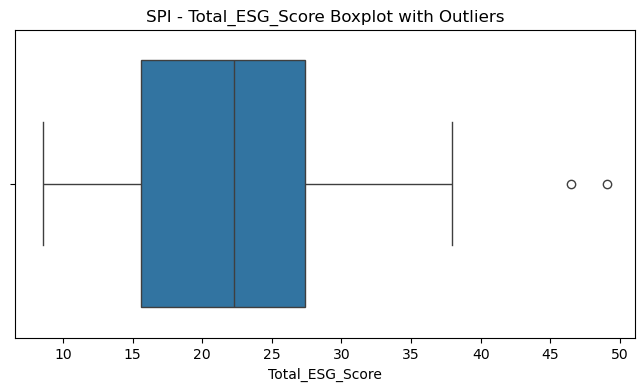

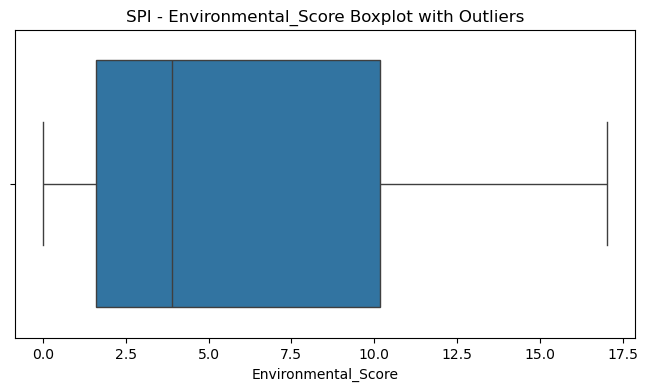

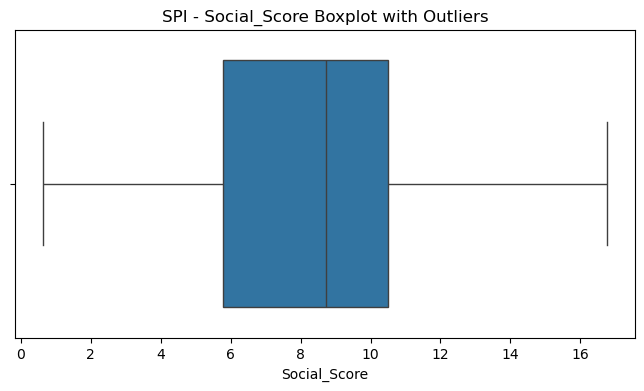

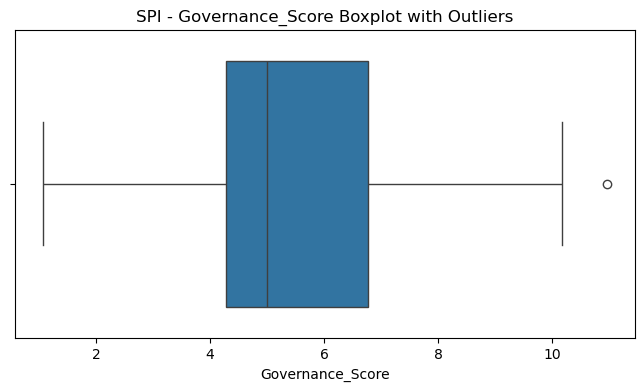

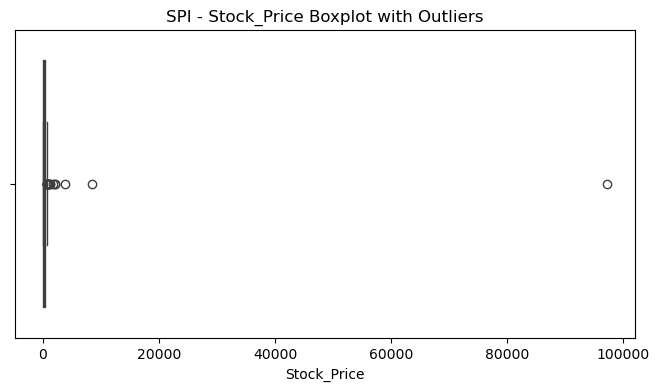

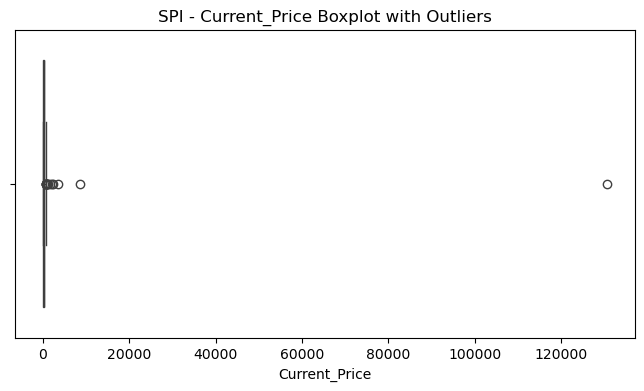

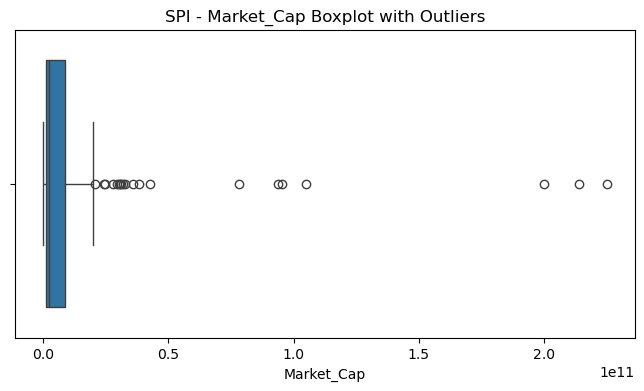

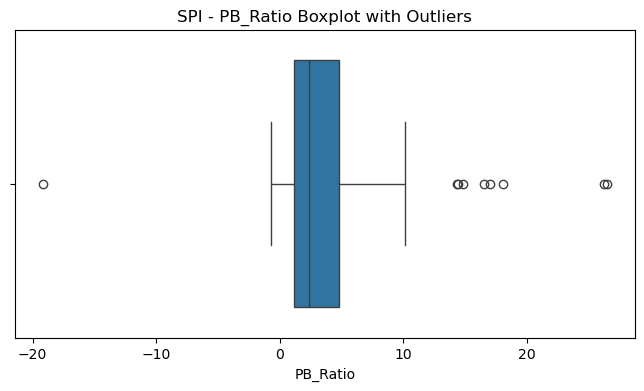

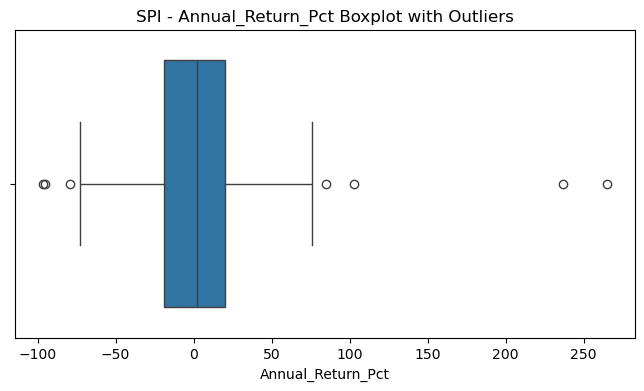

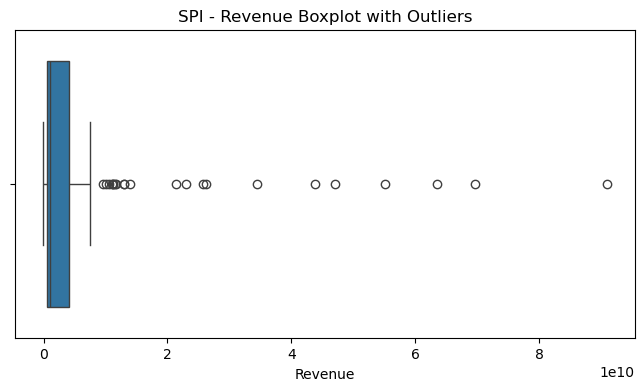

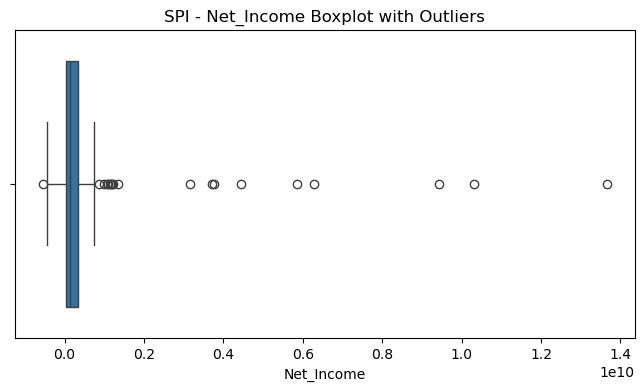

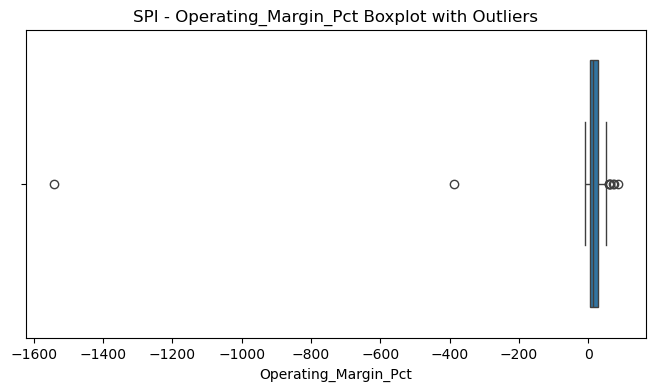

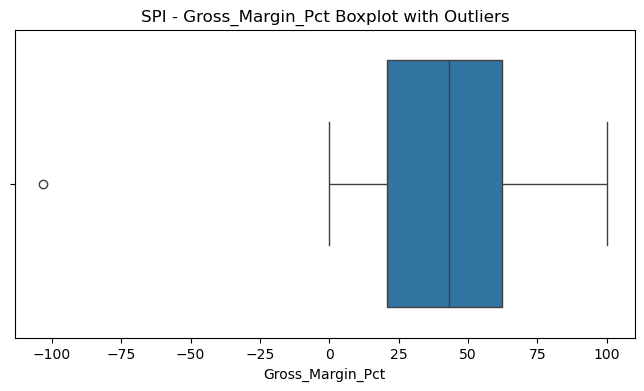

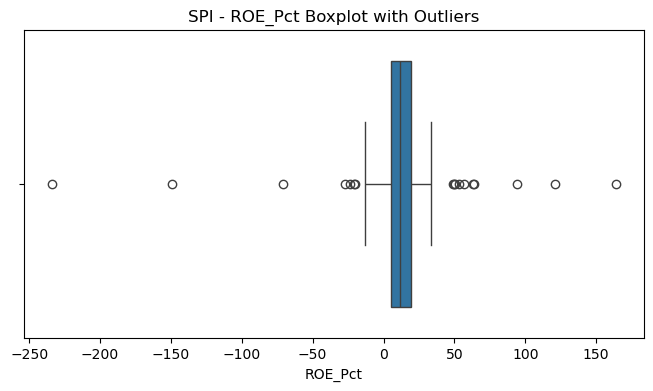

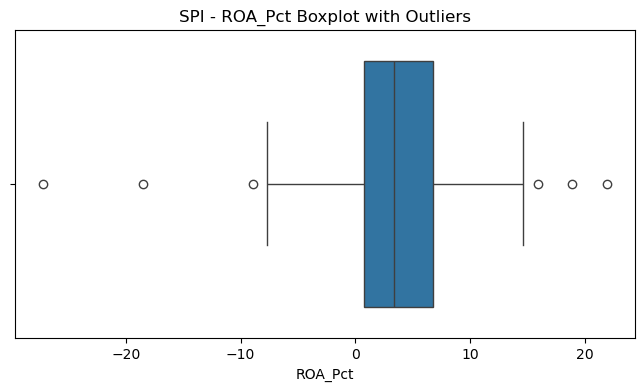

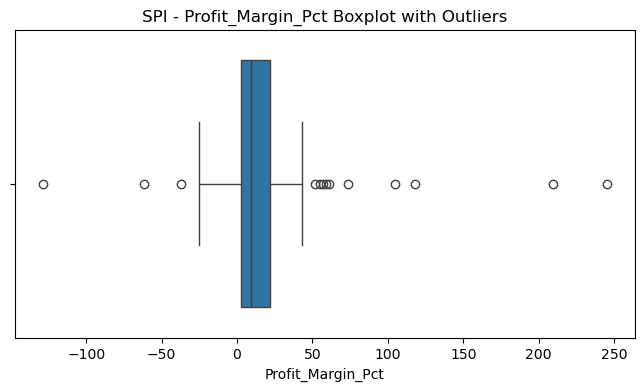

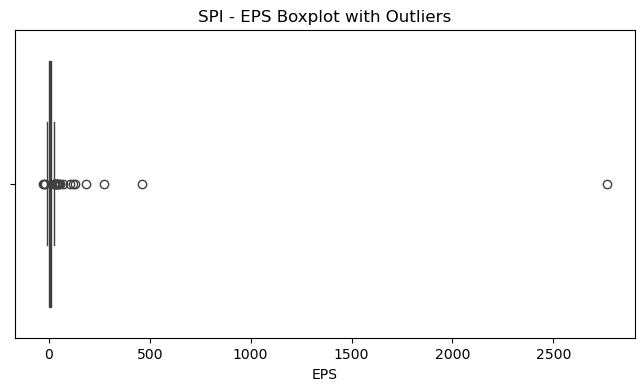

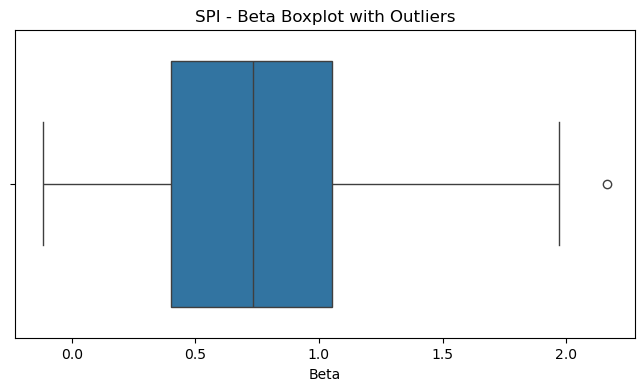

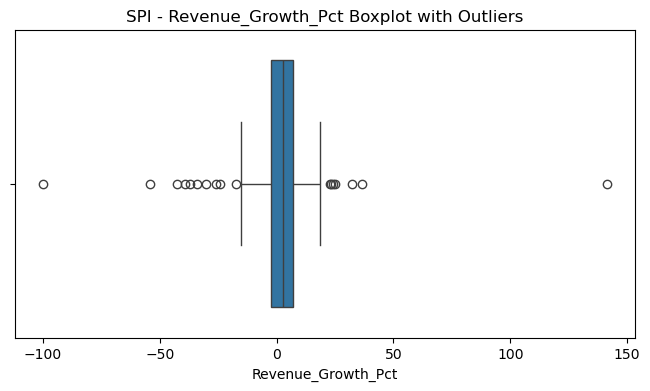

In [42]:
plot_outliers(spi_esg, "SPI")

Boxplots help us visually identify where extreme values occur for specific metrics. Given that our effective ESG sample size is limited, we do not handle extreme values during the data preparation stage, as such extreme values may be legitimate.

TODO: Addressing outliers (keep or remove them) during the analysis and comparison of specific metrics, based on the observed distributions

## 3.7 Enrich Dataset with Additional Information

### 3.7.1 Add Company_Type column for identification before merging

In [31]:
spi_esg['Company_Type'] = "SPI"
sp500_esg['Company_Type'] = "S&P 500"

### 3.7.2 ESG Risk Classification

Yahoo Finance utilizes Sustainalytics’ ESG Risk Ratings, which categorize companies into five levels: Negligible, Low, Medium, High, and Severe. These ratings are visually represented using ESG Globe icons, where **Low numbers indicate a low risk, whereas higher numbers indicate a higher risk**. This classification is widely used in ESG data analysis and investment decision-making.

**ESG Risk Categories at Overall Level** 
(according to [ESG Risk Ratings Methodology](https://www.sustainalytics.com/docs/knowledgehublibraries/default-document-library/sustainalytics_-esg-risk-ratings_-version-3-1_-methodology-abstract_-june-2024.pdf))

A company’s ESG Risk Ratings score on Overall Level is assigned to one of five ESG risk categories in the ESG Risk Ratings:
- Negligible risk (overall unmanaged risk score between 0 and 9.99 points): ESG factors are considered to drive negligible risk to enterprise value.
- Low risk (overall unmanaged risk score between 10 and 19.99 points): ESG factors are considered to drive low risk to enterprise value.
- Medium risk (overall unmanaged risk score between 20 and 29.99 points): ESG factors are considered to drive medium risk to enterprise value.
- High risk (overall unmanaged risk score between 30 and 39.99 points): ESG factors are considered to drive high risk to enterprise value.
- Severe risk (overall unmanaged risk score 40 points and above): ESG factors are considered to drive severe risk to enterprise value.

Note: Because ESG risks materialize at an unknown time in the future and depend on a variety of unpredictable conditions, no predictions on financial or share price impacts, or on the time horizon of such impacts, are intended or implied by these risk categories.

In [32]:
def categorize_esg_risk(score):
    if pd.isna(score):
        return np.nan
    elif score < 10:
        return 'Negligible'
    elif score < 20:
        return 'Low'
    elif score < 30:
        return 'Medium'
    elif score < 40:
        return 'High'
    else:
        return 'Severe'
    
spi_esg['ESG_Risk_Category'] = spi_esg['Total_ESG_Score'].apply(categorize_esg_risk)
spi_esg['ESG_Risk_Category'] = spi_esg['ESG_Risk_Category'].astype('category')

In [36]:
sp500_esg['ESG_Risk_Category'] = sp500_esg['Total_ESG_Score'].apply(categorize_esg_risk)
sp500_esg['ESG_Risk_Category'] = sp500_esg['ESG_Risk_Category'].astype('category')

### 3.7.3 Reorder columns for better readability

In [37]:
cols = list(spi_esg.columns)
cols.remove('Company_Type')
idx = cols.index('Company_Name') + 1
cols.insert(idx, 'Company_Type')
spi_esg = spi_esg[cols]

In [38]:
cols = list(spi_esg.columns)
cols.remove('ESG_Risk_Category')
idx = cols.index('Country') + 1
cols.insert(idx, 'ESG_Risk_Category')
spi_esg = spi_esg[cols]

In [39]:
cols = list(sp500_esg.columns)
cols.remove('Company_Type')
idx = cols.index('Company_Name') + 1
cols.insert(idx, 'Company_Type')

cols.remove('ESG_Risk_Category')
idx = cols.index('Country') + 1
cols.insert(idx, 'ESG_Risk_Category')

sp500_esg = sp500_esg[cols]

## 3.8 Format Dataset for Analysis

### 3.8.1 Remove columns with identical value

In [40]:
esg_clean = pd.concat([spi_esg, sp500_esg], ignore_index=True)

In [41]:
cols_to_drop = [col for col in esg_clean.columns if esg_clean[col].nunique() == 1]

esg_clean = esg_clean.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop)

Dropped columns: ['Data_Date', 'Status']


### 3.8.2 Save Cleaned Datasets

In [42]:
esg_clean.to_csv("Data/cleaned_combined_data.csv", index=False)

# 4. Analysis and Visualization

## 4.1 Light Exploratory Data Analysis
- Industry Distribution
- ESG Distribution

### 4.1.1 Industry Distribution

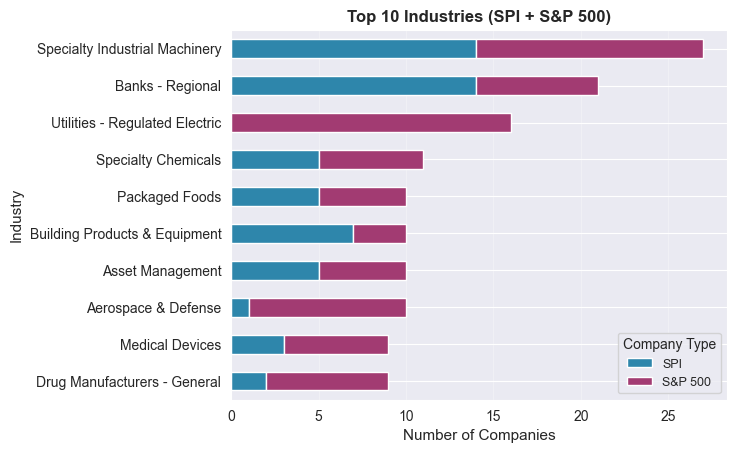

In [43]:
# Top 10 industries by overall company count
top_industries = esg_clean['Industry'].value_counts().head(10).index
top_ind = esg_clean[esg_clean['Industry'].isin(top_industries)]

industry_type_counts = pd.crosstab(top_ind['Industry'], top_ind['Company_Type'])
industry_type_counts = industry_type_counts[['SPI', 'S&P 500']]
industry_type_counts['Total'] = industry_type_counts.sum(axis=1)
industry_type_counts = industry_type_counts.sort_values(by='Total', ascending=True)
industry_type_counts = industry_type_counts.drop(columns='Total')

# figure
industry_type_counts.plot(kind='barh', stacked=True, 
                         color=['#2E86AB', '#A23B72'])

plt.xlabel('Number of Companies', fontsize=11)
plt.ylabel('Industry', fontsize=11)
plt.title('Top 10 Industries (SPI + S&P 500)', fontsize=12, fontweight='bold')
plt.legend(title='Company Type', fontsize=9)
plt.grid(axis='x', alpha=0.3)

plt.show()

**Top 10 Industries according to SPI counts**

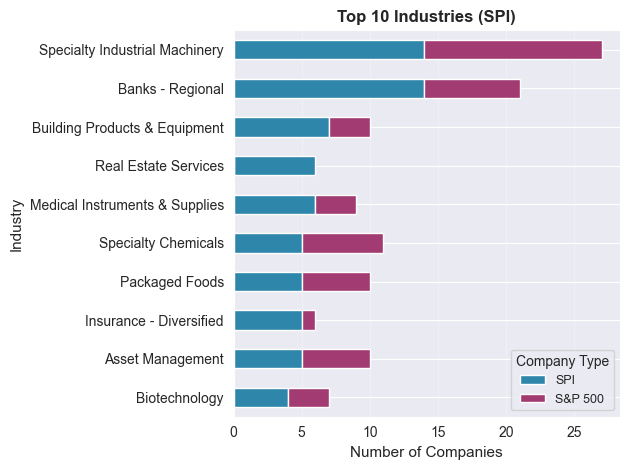

In [44]:
spi_companies = esg_clean[esg_clean['Company_Type'] == 'SPI']
top_spi_industries = spi_companies['Industry'].value_counts().head(10).index

top_spi_ind = esg_clean[esg_clean['Industry'].isin(top_spi_industries)]

industry_spi_counts = pd.crosstab(top_spi_ind['Industry'], top_spi_ind['Company_Type'])
industry_spi_counts = industry_spi_counts[['SPI', 'S&P 500']]
industry_spi_counts = industry_spi_counts.sort_values(by='SPI', ascending=True)

industry_spi_counts.plot(kind='barh', stacked=True, 
                          color=['#2E86AB', '#A23B72'])

plt.xlabel('Number of Companies', fontsize=11)
plt.ylabel('Industry', fontsize=11)
plt.title('Top 10 Industries (SPI)', fontsize=12, fontweight='bold')
plt.legend(title='Company Type', fontsize=9)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.show()

### 4.1.2 ESG Distribution

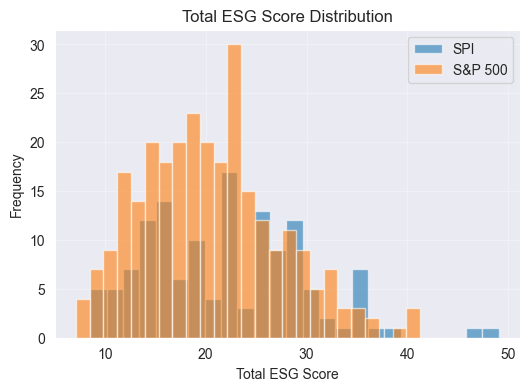

In [45]:
plt.figure(figsize=(6,4))
plt.hist(esg_clean[esg_clean['Company_Type']=='SPI']['Total_ESG_Score'].dropna(), bins=25, alpha=0.6, label='SPI')
plt.hist(esg_clean[esg_clean['Company_Type']=='S&P 500']['Total_ESG_Score'].dropna(), bins=25, alpha=0.6, label='S&P 500')
plt.xlabel('Total ESG Score')
plt.ylabel('Frequency')
plt.title('Total ESG Score Distribution')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

/var/folders/hz/1v624m_x7tb_4prfm9vkrrjw0000gn/T/ipykernel_14027/123533497.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=esg_clean, x='Company_Type', y=col, ax=axes[i], palette=['#2E86AB', '#A23B72'])
/var/folders/hz/1v624m_x7tb_4prfm9vkrrjw0000gn/T/ipykernel_14027/123533497.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=esg_clean, x='Company_Type', y=col, ax=axes[i], palette=['#2E86AB', '#A23B72'])
/var/folders/hz/1v624m_x7tb_4prfm9vkrrjw0000gn/T/ipykernel_14027/123533497.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxp

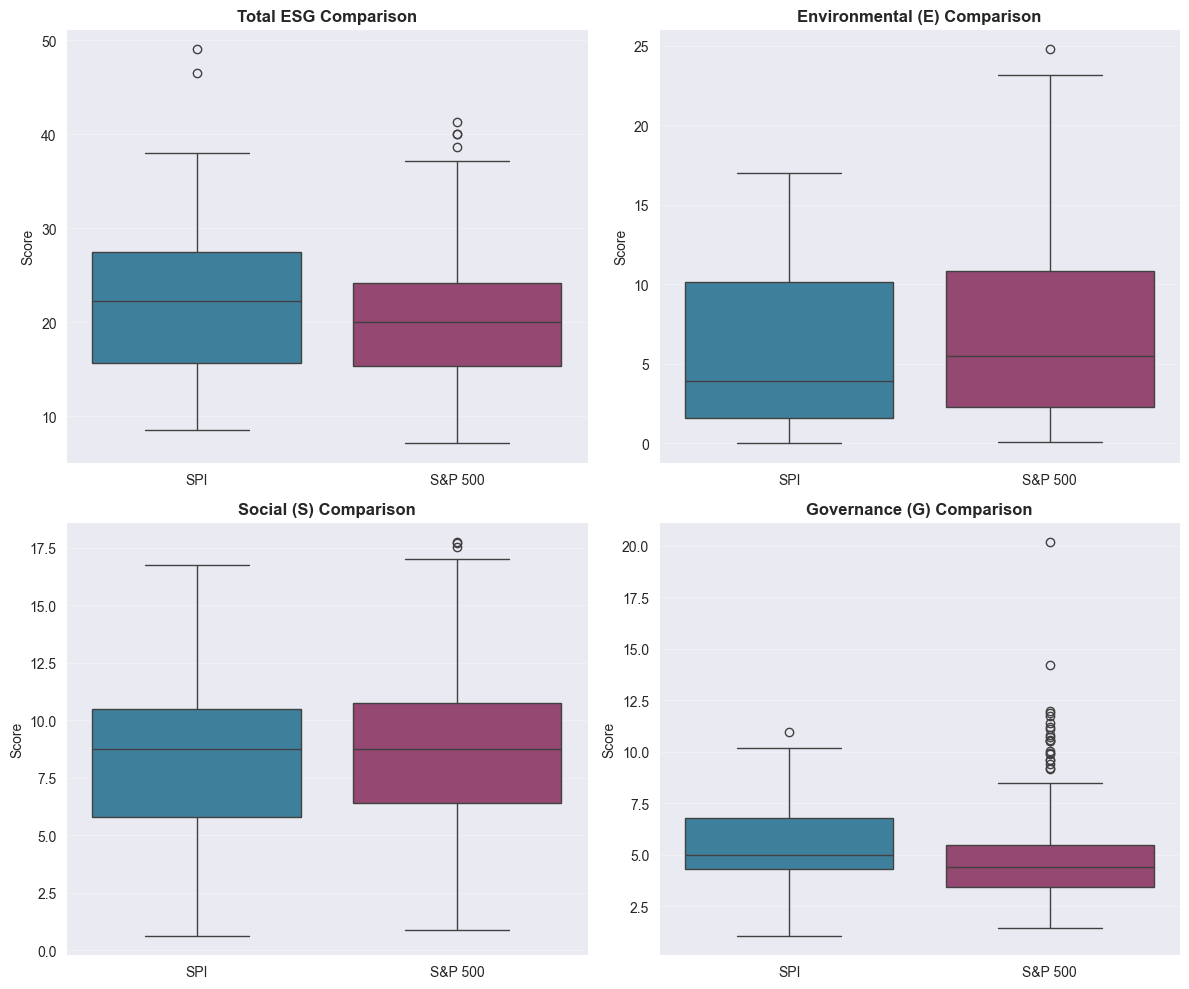

In [46]:
esg_cols = ['Total_ESG_Score', 'Environmental_Score', 'Social_Score', 'Governance_Score']
esg_labels = ['Total ESG', 'Environmental (E)', 'Social (S)', 'Governance (G)']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(esg_cols):
    sns.boxplot(data=esg_clean, x='Company_Type', y=col, ax=axes[i], palette=['#2E86AB', '#A23B72'])
    axes[i].set_title(f'{esg_labels[i]} Comparison', fontsize=12, fontweight='bold')
    axes[i].grid(axis='y', alpha=0.3)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Score')

plt.tight_layout()
plt.show()

<Figure size 700x400 with 0 Axes>

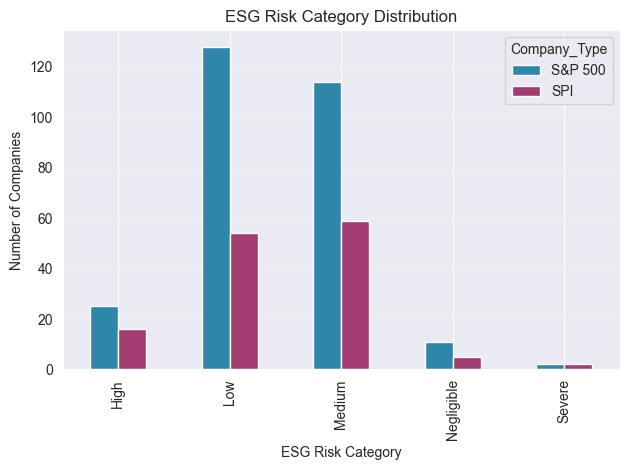

In [47]:
plt.figure(figsize=(7,4))
pd.crosstab(esg_clean['ESG_Risk_Category'], esg_clean['Company_Type']).plot(kind='bar', color=['#2E86AB', '#A23B72'])
plt.xlabel('ESG Risk Category')
plt.ylabel('Number of Companies')
plt.title('ESG Risk Category Distribution')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [48]:
esg_means = esg_clean.groupby('Company_Type')[esg_cols].mean().round(2)
print(esg_means)

              Total_ESG_Score  Environmental_Score  Social_Score  \
Company_Type                                                       
S&P 500                 20.43                 6.94          8.70   
SPI                     22.14                 5.67          8.17   

              Governance_Score  
Company_Type                    
S&P 500                   4.82  
SPI                       5.48  


## 4.2 RQ1: Relationship between financial performance and ESG

To answer this question, we want to look into the relationship of several financial performance indicators with the ESG risk score. We first look at the different variables and whey they are relevant or not for further analysis

| **Indicator**            | **Description**                               | **Relevancy for Financial Performance** | **Remarks**                                   |
| ------------------------ | --------------------------------------------- | --------------------------------------- | --------------------------------------------- |
| **Stock_Price**          | Stock price at reference date                 | ❌ Not relevant                           | Not comparable across firms                   |
| **Current_Price**        | Most recent stock price                       | ❌ Not relevant                            | Used to compute returns                       |
| **Market_Cap**           | Market capitalization (price × shares)        | ⚪ Control variable                      | Proxy for firm size                           |
| **log_mc**               | Log-transformed market capitalization         | ⚪ Control variable                      | Used in regressions for size control          |
| **PB_Ratio**             | Price-to-book ratio                           | ✅ Relevant                              | Measures market valuation vs. book value      |
| **Annual_Return_Pct**    | Annualized stock return (%)                   | ✅ Highly relevant                       | Captures market-based performance             |
| **Revenue**              | Total revenues                                | ⚪ Control variable                      | Use only for scaling or ratios                |
| **Net_Income**           | Total net income                              | ⚪ Control variable                      | Absolute measure, not comparable across firms |
| **Operating_Margin_Pct** | Operating income / revenue                    | ✅ Relevant                              | Core profitability indicator                  |
| **Gross_Margin_Pct**     | Gross profit / revenue                        | ✅ Relevant                              | Indicates production efficiency               |
| **ROE_Pct**              | Return on equity                              | ✅ Relevant                              | Measures profitability to shareholders        |
| **ROA_Pct**              | Return on assets                              | ✅ Relevant                              | Measures efficiency of asset use              |
| **Profit_Margin_Pct**    | Net profit / revenue                          | ✅ Relevant                              | Overall profitability indicator               |
| **EPS**                  | Earnings per share                            | ✅ Relevant                              | Reflects profitability per share              |
| **Beta**                 | Systematic market risk                        | ✅ Relevant                              | Indicates volatility relative to market       |
| **Revenue_Growth_Pct**   | Revenue growth rate (%)                       | ✅ Relevant                              | Measures growth and business momentum         |


For the analysis we want to look closer into these models closer

| **Research Focus**     | **Dependent Variable(s)**                                         | **Control Variables**                         | **Independent Variable (ESG)**      |
| ---------------------- | ----------------------------------------------------------------- | --------------------------------------------- | ----------------------------------- |
| **Market performance** | `Annual_Return_Pct`                                               | `log_mc`, `Revenue_Growth_Pct`, `C(Industry)` | `Total_ESG_Score`                   |
| **Profitability**      | `ROE_Pct`, `ROA_Pct`, `Profit_Margin_Pct`, `Operating_Margin_Pct` | `log_mc`, `C(Industry)`                       | `Total_ESG_Score`                   |
| **Valuation**          | `PB_Ratio`, `EPS`                                                 | `log_mc`, `Revenue_Growth_Pct`, `C(Industry)` | `Total_ESG_Score`                   |
| **Risk profile**       | `Beta`                                                            | `log_mc`, `C(Industry)`                       | `Total_ESG_Score`                   |
| **Growth perspective** | `Revenue_Growth_Pct`                                              | `log_mc`, `C(Industry)`                       | `Total_ESG_Score` or ESG sub-scores |


### 4.2.1 Market performance

#### 4.2.1.1 Data preparation

First prepare the data for the analysis:
1. create a dataset only with the SPI companies
2. log transform market cap to smoothen extreme values
3. choose only those observations with complete data for necessary variables
4. check number of observation per industry to see if we have enough observations

In [49]:
# only SPI dataset from merged data
ch = esg_clean.query("Company_Type == 'SPI'").copy()

# log transformed market cap to smoothen extreme values
ch["log_mc"] = np.log1p(ch["Market_Cap"])

#choose only those entries with complete data in the necessary variables
vars_needed_1 = [
    "Annual_Return_Pct",
    "Total_ESG_Score",
    "log_mc",
    "Revenue_Growth_Pct",
    "Industry"
]

# drop rows with missing values
df_return = ch.dropna(subset=vars_needed_1).copy()
print("N after drop NA:", len(df_return))
df_return[vars_needed_1].describe()


# Check range of ESG and Return values
print("ESG range:", df_return["Total_ESG_Score"].min(), "-", df_return["Total_ESG_Score"].max())
print("Return range:", df_return["Annual_Return_Pct"].min(), "-", df_return["Annual_Return_Pct"].max())

# Industry representation
print("Industries:", df_return["Industry"].nunique())
print(df_return["Industry"].value_counts().head(10))

N after drop NA: 136
ESG range: 8.56 - 49.05
Return range: -96.56 - 264.81
Industries: 49
Industry
Specialty Industrial Machinery    14
Banks - Regional                  14
Building Products & Equipment      7
Medical Instruments & Supplies     6
Real Estate Services               6
Asset Management                   5
Insurance - Diversified            5
Specialty Chemicals                5
Packaged Foods                     5
Biotechnology                      4
Name: count, dtype: int64


- We see that the number of companies per industry is maximum 14. Not surprising when considering that the dataset includes only 136 observations. We will take the low number per industry into account for further analysis.
- When looking at the range of ESG rist, we see that we have a broad Streuung, ranging from negligible up to severy risk.
- the annual return range is quite broad with extreme outliers ranging from losses up to -100% or winnings over +250%. In a next step we check the outliers and will exclude them if necessary.

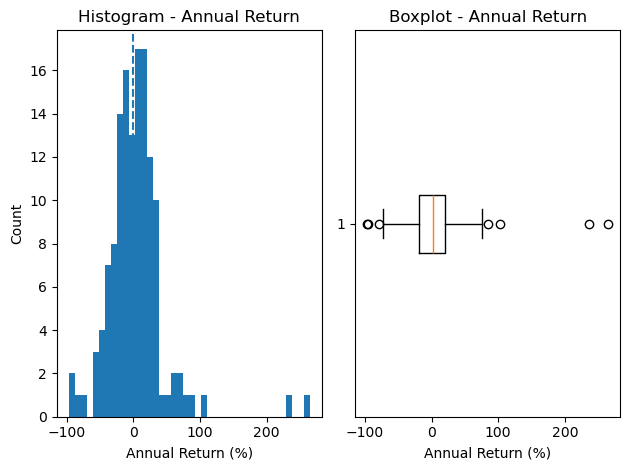

In [59]:
# Histogram + Boxplot
fig, ax = plt.subplots(1, 2)

ax[0].hist(df_return["Annual_Return_Pct"], bins=40)
ax[0].axvline(0, linestyle="--")
ax[0].set_title("Histogram - Annual Return")
ax[0].set_xlabel("Annual Return (%)"); ax[0].set_ylabel("Count")

ax[1].boxplot(df_return["Annual_Return_Pct"].dropna(), vert=False, showfliers=True)
ax[1].set_title("Boxplot - Annual Return")
ax[1].set_xlabel("Annual Return (%)")

plt.tight_layout(); plt.show()


We see that we have 6 outliers according to the boxplot. We want to exclude them from further analysis.

In [50]:
# Compute IQR boundaries
Q1 = df_return["Annual_Return_Pct"].quantile(0.25)
Q3 = df_return["Annual_Return_Pct"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

df_return_no_outliers = df_return[
    (df_return["Annual_Return_Pct"] >= lower_bound) &
    (df_return["Annual_Return_Pct"] <= upper_bound)
].copy()

print(f"Removed {len(df_return) - len(df_return_no_outliers)} outliers")
print(f"Remaining observations: {len(df_return_no_outliers)}")

Q1: -19.23, Q3: 19.87, IQR: 39.09
Lower bound: -77.87, Upper bound: 78.51
Removed 7 outliers
Remaining observations: 129


#### 4.2.1.2 Analysis

We create a scatterplot to analyse the relationship visually.

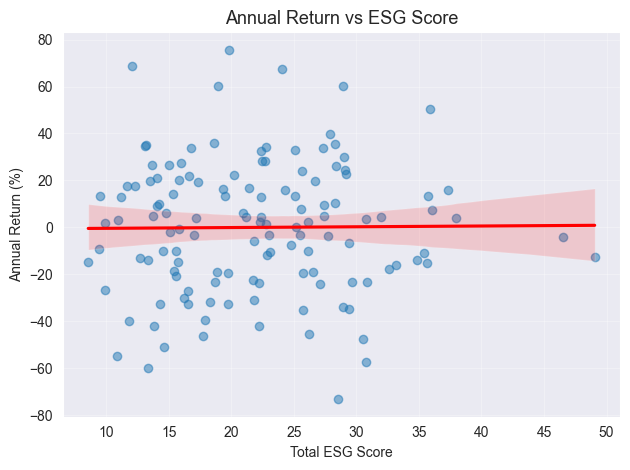

In [51]:
plt.figure()
sns.regplot(
    data=df_return_no_outliers,
    x="Total_ESG_Score",
    y="Annual_Return_Pct",
    scatter_kws={"alpha":0.5},
    line_kws={"color":"red"},
    ci=95
)
plt.title("Annual Return vs ESG Score", fontsize=13)
plt.xlabel("Total ESG Score")
plt.ylabel("Annual Return (%)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The linear fit indicates a very weak (slightly positive) relationship between ESG risk scores and annual returns among SPI companies.
Given that a lower ESG score means lower risk and better ESG performance, this result implies that firms with stronger ESG profiles do not systematically outperform or underperform peers in terms of annual stock returns.
The broad confidence band further suggests that ESG factors alone have limited explanatory power for short-term returns.

Now we run a regression analysis to statistically disentangle the effects and control for several influencing factors, such as:
- **Market capitalization** (log_mc): Larger firms tend to be more diversified, less volatile, and often receive more analyst coverage, which can influence both their ESG performance and financial returns.
- **Revenue growth** (Revenue_Growth_Pct): Rapidly growing firms may experience higher stock returns independent of their ESG profile, so controlling for growth isolates the ESG effect on returns.
- **Industry**: ESG scores and their financial relevance can vary substantially across sectors — for example, environmental factors are more material in manufacturing, while governance plays a stronger role in financial services. Including industry dummies controls for these structural differences.

In [52]:
# How many obs per industry?
counts = df_return_no_outliers["Industry"].value_counts()
keep = counts[counts >= 3].index            # require at least 3 per industry (adjust if you like)

df_fix = df_return_no_outliers.copy()
df_fix["Industry_grp"] = np.where(df_fix["Industry"].isin(keep), df_fix["Industry"], "Other")

# Refit with grouped industry FE
m_ret_clean = smf.ols(
    "Annual_Return_Pct ~ Total_ESG_Score + log_mc + Revenue_Growth_Pct + C(Industry_grp)",
    data=df_fix
).fit(cov_type="HC3") #assumption of heteroscadicity

print(m_ret_clean.summary())



                            OLS Regression Results                            
Dep. Variable:      Annual_Return_Pct   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     8.726
Date:                Sun, 02 Nov 2025   Prob (F-statistic):           8.78e-14
Time:                        12:48:11   Log-Likelihood:                -587.62
No. Observations:                 129   AIC:                             1211.
Df Residuals:                     111   BIC:                             1263.
Df Model:                          17                                         
Covariance Type:                  HC3                                         
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

The adjusted R-squared indicates that the model explains approximately 23% of the variance in annual returns.
Contrary to what we expected based on the visual analysis, the Total ESG Score shows a statistically significant effect (coef = 0.78, p = 0.046). However, the direction of the effect is opposite to our assumption — higher ESG risk (i.e., a higher score) is associated with higher annual returns. The magnitude of this relationship is relatively small, amounting to an increase of about 0.77 percentage points in annual return per ESG-risk point.

The log-transformed market capitalization is highly significant (coef = 6.05, p < 0.001), suggesting that larger companies tend to achieve higher annual returns. In contrast, revenue growth shows no statistically significant relationship with annual returns (coef = 0.03, p = 0.74).

Regarding industry effects, the analysis reveals significantly positive coefficients for:
- Real Estate – Diversified (coef = 37.83, p = 0.005)
- Real Estate Services (coef = 26.98, p = 0.026)
- Banks – Regional (coef = 22.83, p = 0.027)

while Specialty Chemicals is the only sector exhibiting a significant negative effect on annual returns (coef = -25.52, p = 0.014).


now we control for Market cap and industry

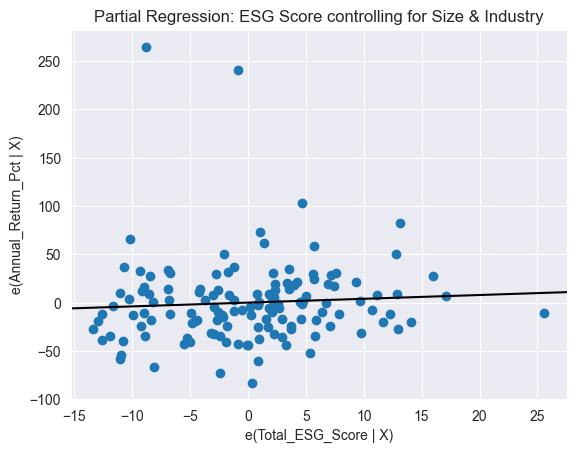

In [53]:
fig = sm.graphics.plot_partregress(
    endog="Annual_Return_Pct",
    exog_i="Total_ESG_Score",
    exog_others=["log_mc", "Revenue_Growth_Pct"],
    data=df_return,
    obs_labels=False
)
plt.title("Partial Regression: ESG Score controlling for Size & Industry")
plt.show()


The partial regression plot visualizes the isolated relationship between the Total ESG Score and the Annual Return, after controlling for firm size (log of market capitalization) and industry effects.

Each point represents the residuals from two regressions:

- On the x-axis: the portion of ESG Score not explained by size and industry.
- On the y-axis: the portion of Annual Return not explained by size and industry.

The fitted line shows the remaining linear association between these residuals. The slightly positive slope indicates that, when holding firm size and industry constant, companies with higher ESG risk (higher ESG scores) tend to exhibit slightly higher annual returns.

However, the relationship is weak, as shown by the flat slope and the high dispersion of points around the regression line. This suggests that ESG risk alone explains little of the remaining variation in returns once structural factors like size and industry are accounted for.

In summary, the partial regression confirms the main regression result: ESG risk has a small but statistically significant positive association with returns, implying that higher-risk firms might be compensated by slightly higher financial performance — though the economic relevance of this effect is limited.

RQ2: What is the effect of the industry type on this relationship, focusing on the top 5 industries in Switzerland.

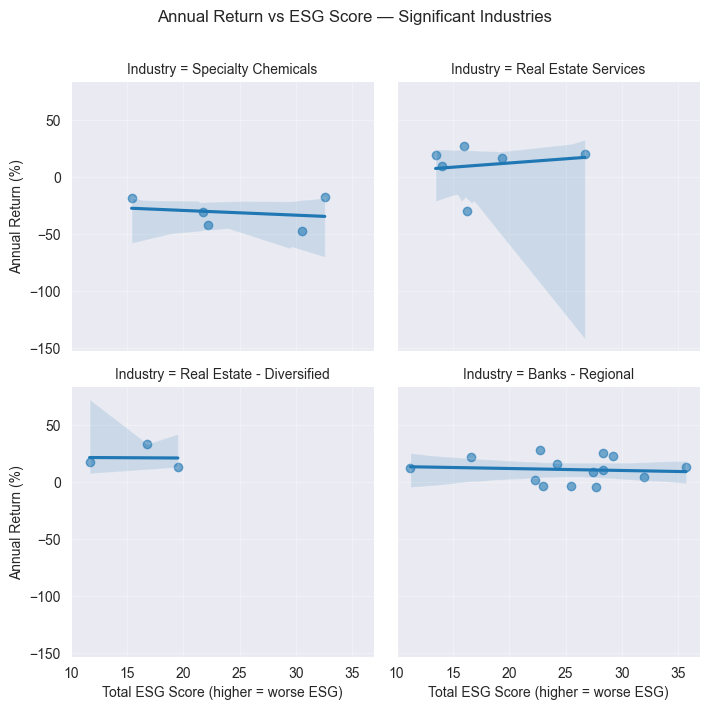

In [54]:
# pick the significant industries (from your regression)
sig_inds = [
    "Real Estate - Diversified",
    "Real Estate Services",
    "Banks - Regional",
    "Specialty Chemicals"
]

# choose which column to use (Industry_grp if you grouped, else Industry)
ind_col = "Industry_grp" if "Industry_grp" in df_return_no_outliers.columns else "Industry"

use_col = "Industry_grp" if "Industry_grp" in df_return_no_outliers.columns else "Industry"
plot_set = df_return_no_outliers[df_return_no_outliers[use_col].isin(sig_inds)].copy()

g = sns.lmplot(
    data=plot_set,
    x="Total_ESG_Score", y="Annual_Return_Pct",
    col=use_col, col_wrap=2, height=3.6,
    scatter_kws={"alpha":0.6}
)
g.set_axis_labels("Total ESG Score (higher = worse ESG)", "Annual Return (%)")
for ax in g.axes.flat:
    ax.grid(alpha=0.3)
plt.subplots_adjust(top=0.88)
g.fig.suptitle("Annual Return vs ESG Score — Significant Industries")
plt.show()


To further explore whether the relationship between ESG performance and annual financial returns varies across industries, we visualized the associations for the sectors that showed significant effects in the regression model: Specialty Chemicals, Real Estate – Diversified, Real Estate Services, and Banks – Regional.

Across these industries, the patterns differ in both direction and magnitude. In Specialty Chemicals and Regional Banks, we observe a slightly negative relationship, suggesting that companies with better ESG scores (lower ESG risk) tend to achieve higher annual returns. Conversely, in Real Estate Services, the relationship appears positive, implying that firms with higher ESG risk might exhibit somewhat higher returns, although this effect is characterized by wide confidence intervals due to limited sample size. For Real Estate – Diversified, the slope is nearly flat, indicating no meaningful association between ESG performance and annual return.

Overall, these results suggest that the financial relevance of ESG factors is industry-dependent, with some sectors potentially rewarding better ESG management, while in others, the relationship appears weak or even reversed. However, given the small number of observations in several industries, these findings should be interpreted with caution and considered indicative rather than conclusive.

4. ESG Subdimensions and Financial Performance

In this section, we explore whether the Environmental (E), Social (S), and Governance (G) components of ESG scores show a clear dependency on companies’ financial performance.  
The goal is to determine **which ESG dimension contributes most strongly** to explaining financial outcomes.

We focus on the following financial performance indicators:
- Return on Equity (ROE)
- Price-to-Earnings Ratio (P/E)
- Annual Return (calculated from stock price changes)

For each metric, we first inspect pairwise correlations and then run a multiple regression model:
\[
\text{Financial Performance} = \beta_0 + \beta_1 E + \beta_2 S + \beta_3 G + \epsilon
\]

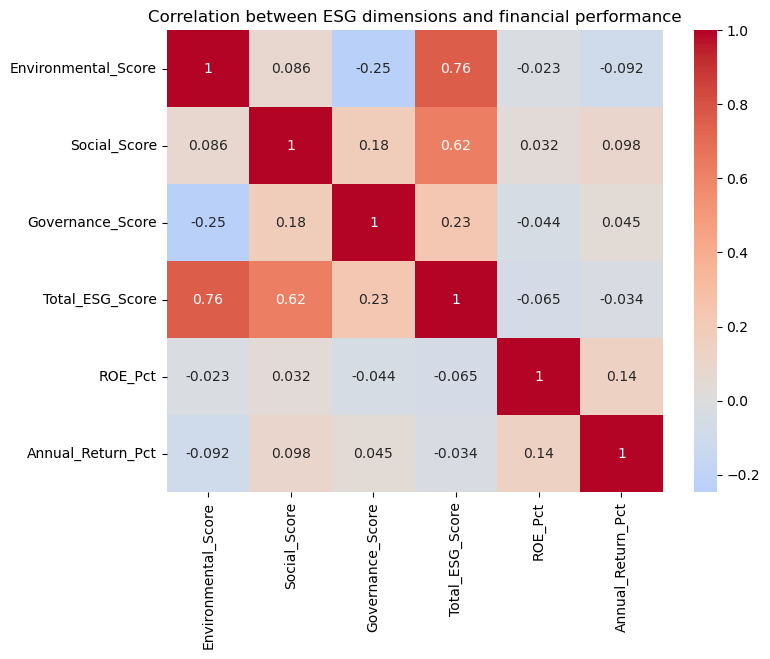

In [82]:
## Compute correlations

# Select only numeric variables needed for correlation
corr_vars = ['Environmental_Score', 'Social_Score', 'Governance_Score', 'Total_ESG_Score', 'ROE_Pct', 'Annual_Return_Pct']
corr_matrix = esg_clean[corr_vars].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between ESG dimensions and financial performance")
plt.show()

The heatmap above shows how the three ESG dimensions (Environmental, Social, and Governance) relate to financial performance indicators such as Return on Equity (ROE) and Annual Return.

The results indicate no strong correlation between ESG factors and financial performance.
While Environmental and Social scores are moderately correlated with the overall ESG score (E=0.76, S=0.62), their correlations with ROE and Annual Return are close to zero or slightly negative.

This suggests that, within the global dataset, higher ESG scores do not systematically translate into better short-term financial results. The weak correlations may indicate that ESG effects on financial performance are indirect, long-term, or vary strongly across industries.

Next, we quantify the relative contribution of E, S, and G factors using a multiple regression model.

In [83]:
## Multiple regression for ROE

# Select and clean
cols = ['Environmental_Score', 'Social_Score', 'Governance_Score', 'ROE_Pct']
df_reg = (esg_clean[cols]
          .apply(pd.to_numeric, errors='coerce')  # ensure numeric types
          .dropna()
          .copy())

# Split X / y
X = df_reg[['Environmental_Score', 'Social_Score', 'Governance_Score']]
X = df_reg[['Environmental_Score', 'Social_Score', 'Governance_Score']]
y = df_reg['ROE_Pct']

# Standardize predictors and KEEP THE INDEX
scaler = StandardScaler()
X_scaled_np = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_np, columns=X.columns, index=X.index)

# Add constant term (no hasconst argument)
X_scaled = sm.add_constant(X_scaled)

# Fit regression
model = sm.OLS(y.loc[X_scaled.index], X_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                ROE_Pct   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5620
Date:                Fri, 31 Oct 2025   Prob (F-statistic):              0.640
Time:                        09:41:40   Log-Likelihood:                -1742.6
No. Observations:                 328   AIC:                             3493.
Df Residuals:                     324   BIC:                             3508.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  26.2046    

The regression model quantifies the individual contributions of E, S, and G to explaining financial performance (ROE).

The coefficients show that:

- Social factors have a small positive effect on ROE,
- Environmental and Governance factors are slightly negative,
- However, none of these effects are statistically significant (all p-values > 0.05).

The model’s R² value of 0.005 means that ESG variables explain less than 1% of the variation in ROE.
--> Overall, this indicates no clear or significant relationship between ESG subdimensions and profitability at the global level.

We can visualize the relative effect sizes to highlight which ESG pillar matters most.

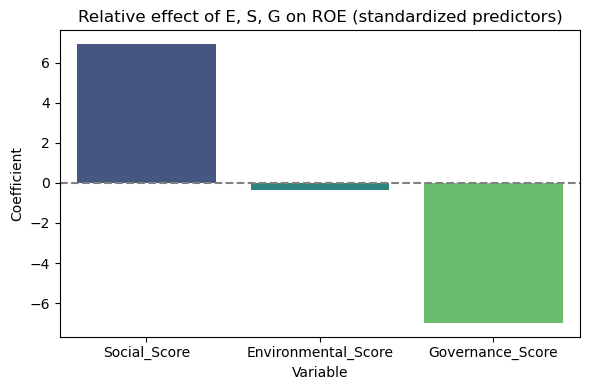

In [76]:
# Build dataframe of coefficients (excluding constant)
coef_df = pd.DataFrame({
    'Variable': model.params.index[1:],  # skip constant
    'Coefficient': model.params.values[1:]
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(
    data=coef_df,
    x='Variable',
    y='Coefficient',
    hue='Variable',         
    palette='viridis',
    legend=False
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Relative effect of E, S, G on ROE (standardized predictors)")
plt.tight_layout()
plt.show()

The visualization illustrates the relative strength and direction of each ESG dimension’s effect on ROE.

- Social_Score shows the largest positive coefficient, suggesting that firms with stronger social practices may experience slightly higher profitability.
- Governance_Score shows the largest negative effect, indicating that stricter governance practices might correspond to lower short-term returns.
- Environmental_Score has only a minor negative influence.

These differences are not statistically significant, but they highlight potential patterns worth further investigation — particularly the consistently positive role of social engagement.

### 5. Comparison: Swiss vs. Global Companies

To assess whether the ESG–financial performance relationship differs between **Swiss firms** and **global peers**,  
we divide the dataset into two groups and compare their correlation and regression results.

This allows us to test whether ESG has a **stronger or weaker link** to financial performance within Switzerland.

In [85]:
## Split datasets
df_swiss = esg_clean[esg_clean['Country'] == 'Switzerland']
df_global = esg_clean[esg_clean['Country'] != 'Switzerland']

print(f"Swiss companies: {len(df_swiss)}, Global companies: {len(df_global)}")

Swiss companies: 136, Global companies: 280


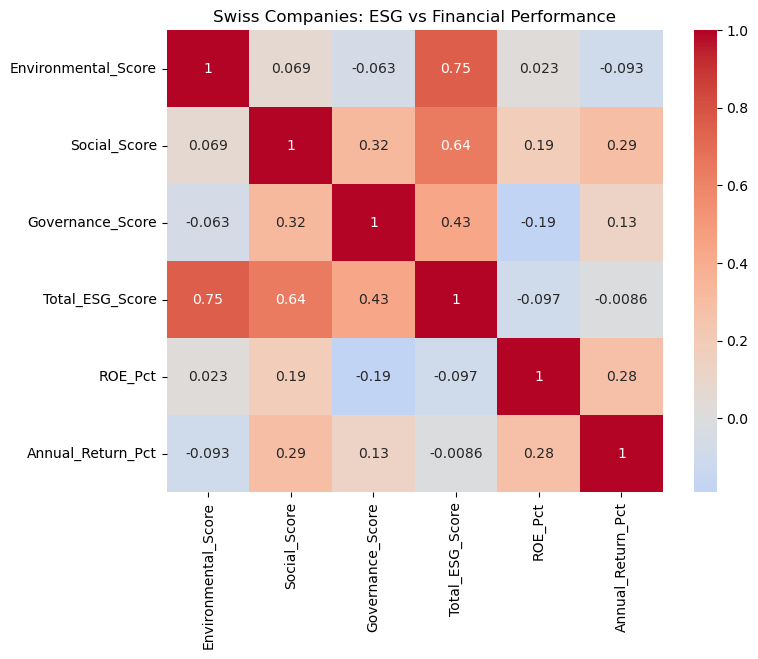

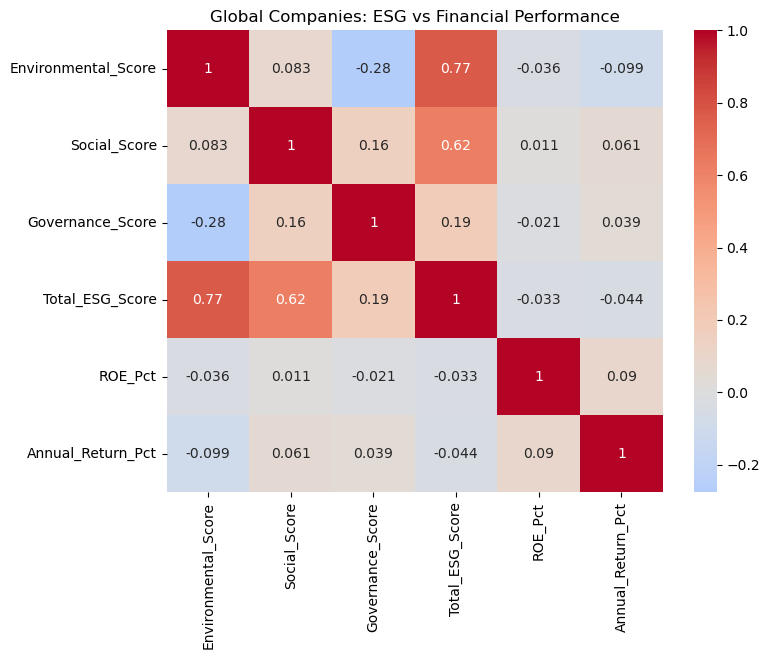

In [86]:
## Compute correlations per group
def plot_corr_by_group(data, title):
    corr = data[corr_vars].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
    plt.title(title)
    plt.show()

plot_corr_by_group(df_swiss, "Swiss Companies: ESG vs Financial Performance")
plot_corr_by_group(df_global, "Global Companies: ESG vs Financial Performance")

By visually comparing the two correlation heatmaps, we can assess differences in the ESG–performance relationships.  
The correlation matrix for Swiss companies shows similar patterns to the global sample.
The Total ESG Score remains strongly correlated with its subdimensions (E=0.75, S=0.64, G=0.43), but correlations with financial indicators (ROE and Annual Return) remain very weak.

Compared to global peers, Swiss firms exhibit a slightly stronger positive link between the Social dimension and financial returns (0.29), which may reflect the high relevance of social responsibility and stakeholder orientation in the Swiss market.

The global results confirm the earlier finding: no meaningful correlation between ESG dimensions and financial performance.

The strongest relationships occur between the ESG subdimensions themselves (e.g., Environmental and Total ESG = 0.77), while ROE and Annual Return correlations remain near zero.

This suggests that for global firms, ESG scores are more internally consistent (E–S–G linked together) than predictive of financial outcomes.

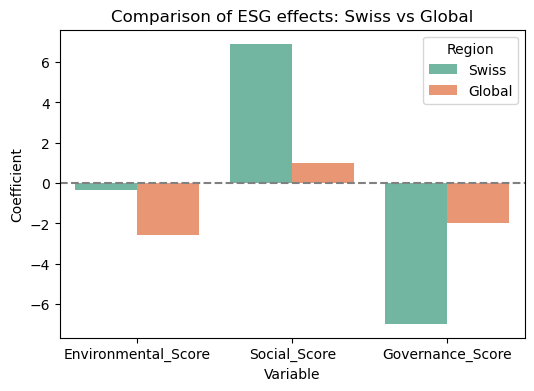

In [88]:
## Compare Regression coefficients across groups

def regression_summary(data, y_var='ROE_Pct'):
    df_reg = data[['Environmental_Score','Social_Score','Governance_Score', y_var]].dropna()
    X = df_reg[['Environmental_Score','Social_Score','Governance_Score']]
    y = df_reg[y_var]
    X_scaled = StandardScaler().fit_transform(X)
    X_scaled = sm.add_constant(X_scaled)
    model = sm.OLS(y, X_scaled).fit()
    return model.params[1:]  # coefficients only

coef_swiss = regression_summary(df_swiss)
coef_global = regression_summary(df_global)

coef_compare = pd.DataFrame({
    'Variable': ['Environmental_Score','Social_Score','Governance_Score'],
    'Swiss': coef_swiss.values,
    'Global': coef_global.values
}).melt(id_vars='Variable', var_name='Region', value_name='Coefficient')

plt.figure(figsize=(6,4))
sns.barplot(data=coef_compare, x='Variable', y='Coefficient', hue='Region', palette='Set2')
plt.title("Comparison of ESG effects: Swiss vs Global")
plt.axhline(0, color='gray', linestyle='--')
plt.show()


The comparison chart highlights how the relative effects of ESG dimensions differ between Swiss and global companies.

- Swiss firms show a strong positive Social effect and a negative Governance effect,
- Global firms display weaker coefficients overall, with the same general direction.

This suggests that while ESG scores are not strong predictors of profitability, the social component seems more relevant for Swiss companies, possibly due to cultural or regulatory differences emphasizing corporate social responsibility and stakeholder relations.

### Interpretation and Discussion

RQ1: “Is there a clear correlation between ESG and financial performance, and how do E, S, G factors compare in explaining it?”
Correlation Heatmap (Global sample)

The Total ESG Score shows moderate positive correlations with its subdimensions (E=0.76, S=0.62, G=0.23).

The correlations with financial performance metrics (ROE_Pct, Annual_Return_Pct) are very weak and slightly negative:

ROE vs. Total ESG: -0.065

Annual Return vs. Total ESG: -0.034
→ This means no strong linear relationship between ESG scores and profitability or returns globally.

OLS Regression (Dependent: ROE_Pct)
Variable	Coefficient	p-value	Interpretation
Environmental_Score	-2.08	0.464	Negative but not significant
Social_Score	+2.25	0.420	Positive but not significant
Governance_Score	-3.06	0.288	Negative but not significant

R² = 0.005, meaning ESG dimensions together explain less than 1% of ROE variance.

None of the E, S, or G effects are statistically significant → financial performance cannot be predicted by ESG subdimensions in this dataset.

Coefficient Visualization

The bar plot confirms:

Social factors have the most positive relative impact on ROE,

Governance shows the most negative,

Environmental has almost no effect.
However, none are significant — so these are tendencies, not causal effects.

🟩 Interpretation:
While the overall ESG score correlates moderately with itself across subdimensions, no clear link exists between ESG and financial performance in the global sample.
If any effect exists, social responsibility seems to have a more positive association with profitability than environmental or governance factors.

RQ2: “How does the correlation between financial performance and ESG scores compare between Swiss companies and global competitors?”
Swiss Companies Correlation

Similar to the global sample, Total ESG is strongly correlated with its components (E=0.75, S=0.64, G=0.43).

The relationship with financial metrics remains very weak:

ROE vs. Total ESG: -0.097

Annual Return vs. Total ESG: -0.009

Slightly higher correlations between Social Score and returns (0.29) compared to global peers.

Comparative Bar Chart (Swiss vs Global)

Swiss firms: Strong positive Social impact (+7), strong negative Governance effect (-7).

Global firms: Weaker overall effects — smaller Social impact (+1) and moderate negative Governance (-2).

Environmental effects are minor in both cases.

🟩 Interpretation:
The direction of effects is consistent between Swiss and global firms, but the magnitude differs:

Swiss companies exhibit stronger positive responsiveness to Social factors and stronger negative sensitivity to Governance ones.

Global firms show weaker effects across all ESG dimensions.

This may reflect differences in:

Corporate governance structures and transparency expectations,

Market maturity,

Cultural emphasis on social responsibility in Switzerland.

4. ESG Subdimensions and Financial Performance

This section examines how environmental (E), social (S), and governance (G) dimensions relate to financial performance, measured through Return on Equity (ROE) and Annual Return.
Both correlation and OLS regression analyses were conducted for global and Swiss company samples.

Global Results

The correlation matrix indicates only weak relationships between ESG scores and financial performance.
While the Total ESG Score correlates strongly with its subcomponents (E=0.76, S=0.62, G=0.23), correlations with ROE and Annual Return are negligible.
The regression analysis confirms that none of the ESG dimensions significantly explain ROE (R² = 0.005).
Among the three, the Social dimension shows the most positive (though insignificant) effect, suggesting that socially responsible practices might slightly enhance profitability, whereas Governance and Environmental factors show small negative tendencies.

Swiss vs. Global Comparison

The correlation patterns for Swiss companies mirror the global results but with slightly stronger interactions.
Social and Governance factors have more pronounced coefficients in the Swiss sample:

Social factors appear more positively linked to ROE,

Governance shows a stronger negative relationship,

Environmental remains neutral.

Overall, no significant correlation between ESG and financial performance is found, but the direction and magnitude of ESG subdimension effects differ between Swiss and global companies.

🟢 Conclusion:
ESG performance does not show a statistically significant effect on financial metrics in either dataset.
However, social engagement seems to be the most positively associated factor, particularly in the Swiss context, while governance aspects may have a dampening effect on returns.